<a href="https://colab.research.google.com/github/belanatal/PosPUCRio/blob/main/MVP-SprintI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint I: Análise de Dados e Boas Práticas (40530010055_20230_01)**

Aluna: Isabela Fernanda Natal Batista Abreu Gomes

Maio/2023

# **Introdução**

## Programa para obtenção, tratamento e análise do histórico de Energia Natural Afluente (ENA), da Energia Armazenada (EArm), da Demanda/Carga e do Custo Marginal da Operação (CMO) por subsistema, a partir da área de Dados Abertos do Operador Nacional do Sistema Elétrico (ONS): [Arquitetura Aberta](https://dados.ons.org.br/)

> Bloco com recuo




> No Brasil, a projeção de preços da energia elétrica baseia-se na previsão, centralizada, de despacho das usinas pelo Operador Nacional do Sistema Elétrico (ONS). 

> Em linhas gerais, o preço da energia, também chamado de Preço de Liquidação das Diferenças (PLD) tem como base o Custo Marginal da Operação (CMO), dado pelo planejamento da operação hidrotérmica do Sistema Interligado Nacional. Os modelos utilizados para projeção oficial do despacho das usinas pelo ONS (Operador Nacional do Sistema) denominam-se NEWAVE, DECOMP e DESSEM, todos desenvolvidos e fornecidos pelo Centro de Pesquisas da Eletrobras (CEPEL), conforme ilustrado na Figura 1.

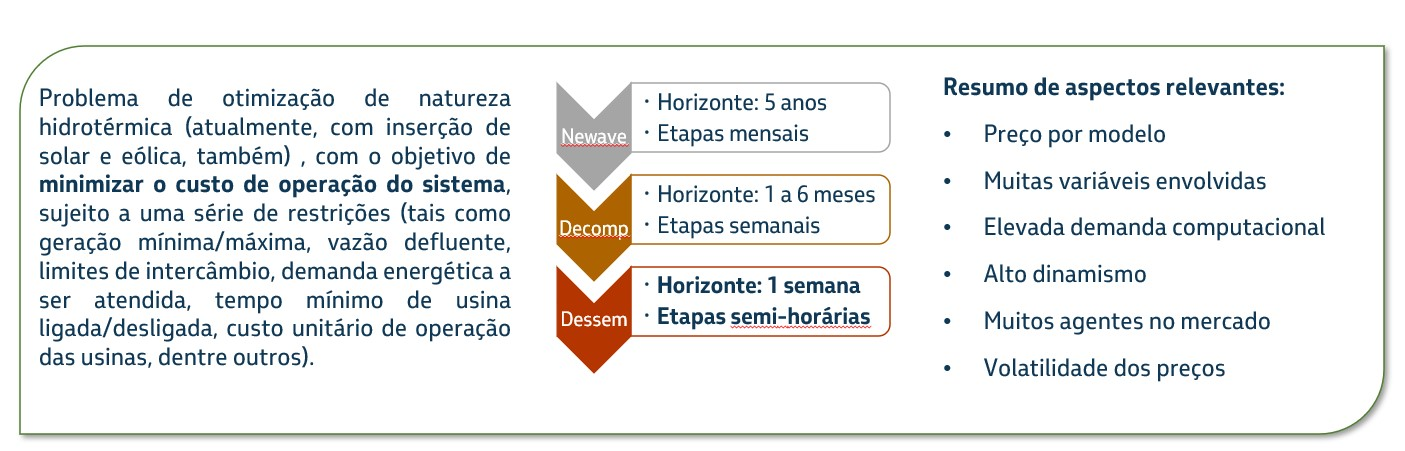

Figura 1 - Resumo do problema de planejamento eletroenergético brasileiro.

> Para a projeção do preço da energia elétrica, uma série de grandezas são utilizadas como entrada. Uma vez que a matriz eletroenergética brasileira é predominantemente hidráulica (e os modelos consideram este aspecto no equacionamento do problema de otimização), a diferença entre as vazões previstas e verificadas dos postos associados às usinas hidroelétricas responde por cerca de 50% das variações no PLD/CMO, conforme ilustrado na Figura 2, disponibilizada pela Câmara de Comercialização de Energia (CCEE). A Energia Armazenada e a Carga também desempenham papel relevante na influência do PLD/CMO. Juntas, as três grandezas respondem por mais de 70% das variações no custo marginal da operação sendo, portanto, as variáveis de interesse na primeira abordagem deste MVP.

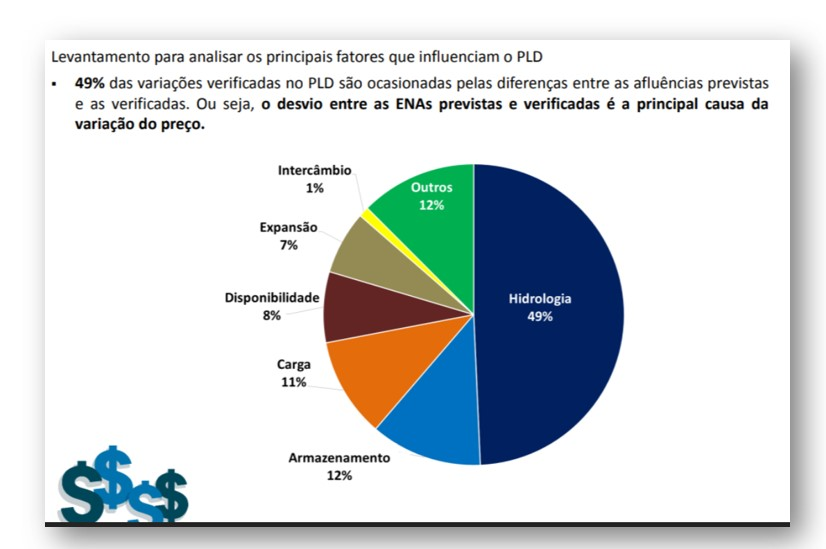

Figura 2 - Variação do PLD/CMO por variável de entrada nos modelos de planejamento eletroenergético do SIN. Fonte: CCEE


> Neste contexto, considerando a atuação na área de Inteligência de Mercado de Gás e Energia em um dos principais agentes geradores do Brasil, faz sentido estruturarmos a coleta e tratamento dos dados referentes às grandezas mencionadas, visando à melhor tomada de decisão sob a ótica da operação do parque e da comercialização e logística do gás e da energia elétrica.





# **Seção I: Obtenção e Tratamento Inicial dos Dados**


1.   [Energia Natural Afluente (ENA) por Subsistema](https://dados.ons.org.br/dataset/ena-diario-por-subsistema)
2.   [Energia Armazenada (EArm) por Subsistema](https://dados.ons.org.br/dataset/ear-diario-por-subsistema)
3.   [Demanda por Subsistema](https://dados.ons.org.br/dataset/carga-energia)
4.   [Custo Marginal da Operação (CMO) Semanal por Subsistema](https://dados.ons.org.br/dataset/cmo-semanal)





> Diariamente, o Operador Nacional do Sistema Elétrico disponibiliza os dados verificados das grandezas supracitadas, para cada um dos 4 subsistemas (Sudeste, Sul, Nordeste e Norte) que compõem eletroenergeticamente o Sistema Interligado Nacional. Para atender ao presente trabalho, estes dados serão tratados, manipulados, pré-processados e avaliados de modo que, em etapas futuras, seja possível aplicar técnicas e algoritmos de Machine Learning a eles, com o objetivo de tentar realizar predições e análises de sensibilidade de Custos Marginais da Operação futuros, por fora dos modelos oficiais.

> Trata-se, portanto, de um problema de Aprendizado Supervisionado, considerando as principais grandezas envolvidas no cálculo do CMO, segundo a Câmara de Comercialização de Energia.



Inicialmente, iremos importar e avaliar (utilizando a biblioteca Pandas, para fazer uma rápida análise exploratória) os dataset de "entrada", variáveis explicativas para a obtenção do CMO: ENA, EArm e Demanda, nesta ordem.

In [208]:
# Primeiro bloco: Importação das bibliotecas e módulos
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
#
# Importando as bibliotecas pandas, matplotlib (pyplot), seaborn e datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
#
## Transformações Numéricas
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização
## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Energia Natural Afluente: ENA

***ENA DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia natural afluente (ENA) dos reservatórios com periodicidade diária por Subsistemas.

A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [209]:
# Seção I.1: Programa para obtenção das Energias Naturais Afluentes - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.
# ENA - Arquivos com os dados anuais, com histórico desde 2001
ano_zero=2001
ano_inicio=ano_zero+1
data_fim=datetime.datetime.now() - datetime.timedelta(days=5) #ano vigente, considerando um possível atraso de até 5 dias na publicação, o que é comum na virada de ano
ano_fim=data_fim.strftime("%Y")
ano_fim=int(ano_fim)
print(data_fim)
print(ano_fim)

2023-04-28 17:42:58.681513
2023


In [210]:
#Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
#Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ena=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
ena=pd.DataFrame(ena)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)  
    ena_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    ena_ano=pd.DataFrame(ena_ano)
    ena=pd.concat([ena,ena_ano])
print(ena)

    id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0               N          NORTE  2001-01-01            10154.000000   
1              NE       NORDESTE  2001-01-01            13472.000000   
2               S            SUL  2001-01-01             7703.000000   
3              SE        SUDESTE  2001-01-01            39186.000000   
4               N          NORTE  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
479            SE        SUDESTE  2023-04-30            50941.132812   
480             N          NORTE  2023-05-01            23575.121094   
481            NE       NORDESTE  2023-05-01             4422.936035   
482             S            SUL  2023-05-01             4635.588867   
483            SE        SUDESTE  2023-05-01            49780.292969   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [211]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
ena.head(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0             N          NORTE  2001-01-01                 10154.0   
1            NE       NORDESTE  2001-01-01                 13472.0   
2             S            SUL  2001-01-01                  7703.0   
3            SE        SUDESTE  2001-01-01                 39186.0   
4             N          NORTE  2001-01-02                  9590.0   
5            NE       NORDESTE  2001-01-02                 13551.0   
6             S            SUL  2001-01-02                  6730.0   
7            SE        SUDESTE  2001-01-02                 41230.0   
8             N          NORTE  2001-01-03                  9066.0   
9            NE       NORDESTE  2001-01-03                 13551.0   

   ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                      122.339996                        9033.0   
1                      101.480003                       13385.0   
2                      160.910004                        7703.0   
3                       86.980003                       37611.0   
4                      115.550003                        8091.0   
5                      102.080002                       13465.0   
6                      140.580002                        6730.0   
7                       91.519997                       40063.0   
8                      109.239998                        7213.0   
9                      102.080002                       13461.0   

   ena_armazenavel_regiao_percentualmlt  
0                            108.839996  
1                            100.830002  
2                            160.910004  
3                             83.489998  
4                             97.489998  
5                            101.430000  
6                            140.580002  
7                             88.930000  
8                             86.910004  
9                            101.400002

In [212]:
# Conferindo as últimas 10 linhas
ena.tail(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
474             S            SUL  2023-04-29             5510.526855   
475            SE        SUDESTE  2023-04-29            52268.253906   
476             N          NORTE  2023-04-30            24095.126953   
477            NE       NORDESTE  2023-04-30             4427.887207   
478             S            SUL  2023-04-30             5032.236816   
479            SE        SUDESTE  2023-04-30            50941.132812   
480             N          NORTE  2023-05-01            23575.121094   
481            NE       NORDESTE  2023-05-01             4422.936035   
482             S            SUL  2023-05-01             4635.588867   
483            SE        SUDESTE  2023-05-01            49780.292969   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
474                       84.711700                   5155.084961   
475                       95.466698                  34924.195312   
476                       89.347702                  16765.867188   
477                       38.530800                   4409.296875   
478                       77.359100                   4769.213867   
479                       93.042702                  32174.042969   
480                      115.763100                  15795.081055   
481                       63.729099                   4402.201172   
482                       54.423801                   4072.472900   
483                      124.727600                  32157.673828   

     ena_armazenavel_regiao_percentualmlt  
474                             79.247597  
475                             63.788200  
476                             62.169899  
477                             38.368999  
478                             73.315697  
479                             58.765099  
480                             77.560097  
481                             63.430302  
482                             47.812599  
483                             80.573097

In [213]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(ena)/4

8156.0

In [214]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                            object
nom_subsistema                           object
ena_data                                 object
ena_bruta_regiao_mwmed                  float64
ena_bruta_regiao_percentualmlt          float64
ena_armazenavel_regiao_mwmed            float64
ena_armazenavel_regiao_percentualmlt    float64
dtype: object

In [215]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
ena['nom_subsistema']=ena['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [216]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
ena=ena.rename(columns = {'ena_data':'Data'})
print(ena)

    id_subsistema nom_subsistema        Data  ena_bruta_regiao_mwmed  \
0               N          Norte  2001-01-01            10154.000000   
1              NE       Nordeste  2001-01-01            13472.000000   
2               S            Sul  2001-01-01             7703.000000   
3              SE        Sudeste  2001-01-01            39186.000000   
4               N          Norte  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
479            SE        Sudeste  2023-04-30            50941.132812   
480             N          Norte  2023-05-01            23575.121094   
481            NE       Nordeste  2023-05-01             4422.936035   
482             S            Sul  2023-05-01             4635.588867   
483            SE        Sudeste  2023-05-01            49780.292969   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [217]:
# Alterando o tipo da coluna "Data"
ena['Data'] = pd.to_datetime(ena['Data'])

In [218]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                                   object
nom_subsistema                                  object
Data                                    datetime64[ns]
ena_bruta_regiao_mwmed                         float64
ena_bruta_regiao_percentualmlt                 float64
ena_armazenavel_regiao_mwmed                   float64
ena_armazenavel_regiao_percentualmlt           float64
dtype: object

In [219]:
# Reordenando o dataframe ena, pela coluna Data (em ordem decrescente)
ena=ena.sort_values(by='Data', ascending=False)
ena.head(20)

id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
483            SE        Sudeste 2023-05-01            49780.292969   
482             S            Sul 2023-05-01             4635.588867   
481            NE       Nordeste 2023-05-01             4422.936035   
480             N          Norte 2023-05-01            23575.121094   
479            SE        Sudeste 2023-04-30            50941.132812   
478             S            Sul 2023-04-30             5032.236816   
477            NE       Nordeste 2023-04-30             4427.887207   
476             N          Norte 2023-04-30            24095.126953   
475            SE        Sudeste 2023-04-29            52268.253906   
474             S            Sul 2023-04-29             5510.526855   
473            NE       Nordeste 2023-04-29             4433.074219   
472             N          Norte 2023-04-29            24507.132812   
470             S            Sul 2023-04-28             6040.722168   
468             N          Norte 2023-04-28            24874.296875   
469            NE       Nordeste 2023-04-28             4414.055176   
471            SE        Sudeste 2023-04-28            53606.066406   
467            SE        Sudeste 2023-04-27            54910.460938   
466             S            Sul 2023-04-27             6542.254883   
465            NE       Nordeste 2023-04-27             4322.590820   
464             N          Norte 2023-04-27            25292.248047   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
483                      124.727600                  32157.673828   
482                       54.423801                   4072.472900   
481                       63.729099                   4402.201172   
480                      115.763100                  15795.081055   
479                       93.042702                  32174.042969   
478                       77.359100                   4769.213867   
477                       38.530800                   4409.296875   
476                       89.347702                  16765.867188   
475                       95.466698                  34924.195312   
474                       84.711700                   5155.084961   
473                       38.575901                   4422.349121   
472                       90.875397                  17544.529297   
470                       92.862297                   5899.597168   
468                       92.236900                  18514.529297   
469                       38.410400                   4406.904785   
471                       97.910202                  39098.992188   
467                      100.292603                  41375.707031   
466                      100.572197                   6173.395996   
465                       37.614498                   4306.860840   
464                       93.786697                  17999.945312   

     ena_armazenavel_regiao_percentualmlt  
483                             80.573097  
482                             47.812599  
481                             63.430302  
480                             77.560097  
479                             58.765099  
478                             73.315697  
477                             38.368999  
476                             62.169899  
475                             63.788200  
474                             79.247597  
473                             38.482601  
472                             65.057198  
470                             90.692802  
468                             68.654099  
469                             38.348202  
471                             71.413399  
467                             75.571701  
466                             94.901802  
465                             37.477600  
464                             66.746002

## Energia Armazenada: EArm

***EAR DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia armazenada (EAR) em periodicidade diária por Subsistemas.

A Energia Armazenada (EAR) representa a energia associada ao volume de água disponível nos reservatórios que pode ser convertido em geração na própria usina e em todas as usinas à jusante na cascata. A grandeza de EAR leva em conta nível verificado nos reservatórios na data de referência. A grandeza de EAR máxima representa a capacidade de armazenamento caso todos os reservatórios do sistema estivessem cheios. A grandeza de EAR para o subsistema à jusante considera a utilização da água do reservatório para produzir energia em uma usina à jusante que está em um subsistema diferente.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [220]:
# Seção I.2: Programa para obtenção das Energias Armazenadas - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# EArm - Arquivos com os dados anuais, com histórico desde 2001. 
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
earm=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
earm=pd.DataFrame(earm)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)  
    earm_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    earm_ano=pd.DataFrame(earm_ano)
    earm=pd.concat([earm,earm_ano])
print (earm)

    id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0              NE       NORDESTE  2001-01-01        49967.000000   
1               N          NORTE  2001-01-01        12311.000000   
2              SE        SUDESTE  2001-01-01       159081.000000   
3               S            SUL  2001-01-01        14176.000000   
4              NE       NORDESTE  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
479             S            SUL  2023-04-30        20459.242188   
480            NE       NORDESTE  2023-05-01        51691.226562   
481             N          NORTE  2023-05-01        15302.396484   
482            SE        SUDESTE  2023-05-01       204615.328125   
483             S            SUL  2023-05-01        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [221]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
earm.head(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0            NE       NORDESTE  2001-01-01             49967.0   
1             N          NORTE  2001-01-01             12311.0   
2            SE        SUDESTE  2001-01-01            159081.0   
3             S            SUL  2001-01-01             14176.0   
4            NE       NORDESTE  2001-01-02             49967.0   
5             N          NORTE  2001-01-02             12311.0   
6            SE        SUDESTE  2001-01-02            159081.0   
7             S            SUL  2001-01-02             14176.0   
8            NE       NORDESTE  2001-01-03             49967.0   
9             N          NORTE  2001-01-03             12311.0   

   ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                     18699.0                        37.419998  
1                      9137.0                        74.220001  
2                     46315.0                        29.110001  
3                     12857.0                        90.690002  
4                     18851.0                        37.730000  
5                      9327.0                        75.760002  
6                     46850.0                        29.450001  
7                     12920.0                        91.139999  
8                     19047.0                        38.119999  
9                      9453.0                        76.779999

In [222]:
# Conferindo as últimas 10 linhas
earm.tail(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
474            SE        SUDESTE  2023-04-29       204615.328125   
475             S            SUL  2023-04-29        20459.242188   
476            NE       NORDESTE  2023-04-30        51691.226562   
477             N          NORTE  2023-04-30        15302.396484   
478            SE        SUDESTE  2023-04-30       204615.328125   
479             S            SUL  2023-04-30        20459.242188   
480            NE       NORDESTE  2023-05-01        51691.226562   
481             N          NORTE  2023-05-01        15302.396484   
482            SE        SUDESTE  2023-05-01       204615.328125   
483             S            SUL  2023-05-01        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
474               176291.843750                        86.157700  
475                17180.095703                        83.972298  
476                46988.765625                        90.902802  
477                15060.443359                        98.418900  
478               176365.890625                        86.193901  
479                17185.806641                        84.000198  
480                46961.621094                        90.850304  
481                15101.476562                        98.686996  
482               176417.734375                        86.219200  
483                17169.437500                        83.920197

In [223]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(earm)/4

8156.0

In [224]:
# Verificando os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                       object
nom_subsistema                      object
ear_data                            object
ear_max_subsistema                 float64
ear_verif_subsistema_mwmes         float64
ear_verif_subsistema_percentual    float64
dtype: object

In [225]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
earm['nom_subsistema']=earm['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [226]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
earm=earm.rename(columns = {'ear_data':'Data'})
print(earm)

    id_subsistema nom_subsistema        Data  ear_max_subsistema  \
0              NE       Nordeste  2001-01-01        49967.000000   
1               N          Norte  2001-01-01        12311.000000   
2              SE        Sudeste  2001-01-01       159081.000000   
3               S            Sul  2001-01-01        14176.000000   
4              NE       Nordeste  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
479             S            Sul  2023-04-30        20459.242188   
480            NE       Nordeste  2023-05-01        51691.226562   
481             N          Norte  2023-05-01        15302.396484   
482            SE        Sudeste  2023-05-01       204615.328125   
483             S            Sul  2023-05-01        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [227]:
# Alterando o tipo da coluna "Data"
earm['Data'] = pd.to_datetime(earm['Data'])

In [228]:
# Verificando novamente os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                              object
nom_subsistema                             object
Data                               datetime64[ns]
ear_max_subsistema                        float64
ear_verif_subsistema_mwmes                float64
ear_verif_subsistema_percentual           float64
dtype: object

In [229]:
# Reordenando o dataframe earm, pela coluna Data (em ordem decrescente)
earm=earm.sort_values(by='Data', ascending=False)
earm.head(20)

id_subsistema nom_subsistema       Data  ear_max_subsistema  \
483             S            Sul 2023-05-01        20459.242188   
482            SE        Sudeste 2023-05-01       204615.328125   
481             N          Norte 2023-05-01        15302.396484   
480            NE       Nordeste 2023-05-01        51691.226562   
479             S            Sul 2023-04-30        20459.242188   
478            SE        Sudeste 2023-04-30       204615.328125   
477             N          Norte 2023-04-30        15302.396484   
476            NE       Nordeste 2023-04-30        51691.226562   
475             S            Sul 2023-04-29        20459.242188   
474            SE        Sudeste 2023-04-29       204615.328125   
473             N          Norte 2023-04-29        15302.396484   
472            NE       Nordeste 2023-04-29        51691.226562   
470            SE        Sudeste 2023-04-28       204615.328125   
468            NE       Nordeste 2023-04-28        51691.226562   
469             N          Norte 2023-04-28        15302.396484   
471             S            Sul 2023-04-28        20459.242188   
467             S            Sul 2023-04-27        20459.242188   
466            SE        Sudeste 2023-04-27       204615.328125   
465             N          Norte 2023-04-27        15302.396484   
464            NE       Nordeste 2023-04-27        51691.226562   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
483                17169.437500                        83.920197  
482               176417.734375                        86.219200  
481                15101.476562                        98.686996  
480                46961.621094                        90.850304  
479                17185.806641                        84.000198  
478               176365.890625                        86.193901  
477                15060.443359                        98.418900  
476                46988.765625                        90.902802  
475                17180.095703                        83.972298  
474               176291.843750                        86.157700  
473                15005.153320                        98.057503  
472                47016.683594                        90.956802  
470               176390.250000                        86.205803  
468                47043.597656                        91.008904  
469                14965.278320                        97.796997  
471                17181.685547                        83.980103  
467                17232.414062                        84.227997  
466               176591.140625                        86.304001  
465                14965.646484                        97.799400  
464                47072.203125                        91.064201

## Carga (Demanda) Eletroenergética

***CARGA DE ENERGIA DIÁRIA*** (Segundo o ONS)

Dados de carga por subsistema em base diária, medida em MWmed.

Até fevereiro/2021, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS. Entre março/2021 e abril/23, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS, mais a previsão de geração de usinas não despachadas pelo ONS. A partir de 29/04/2023, além dos dados anteriormente considerados, passou a ser incorporado o valor estimado da micro e minigeração distribuída (MMGD), com base em dados meteorológicos previstos.

In [230]:
# Seção I.3: Programa para obtenção da Carga Elétrica - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# Carga - Arquivos com os dados anuais, com histórico desde 2001. 
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
carga=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
carga=pd.DataFrame(carga)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)  
    carga_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    carga_ano=pd.DataFrame(carga_ano)
    carga=pd.concat([carga,carga_ano])
print(carga)

    id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0               N                 Norte   2001-01-01            2376.731250
1              NE              Nordeste   2001-01-01            5035.816667
2               S                   Sul   2001-01-01            4925.373750
3              SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4               N                 Norte   2001-01-02            2537.383333
..            ...                   ...          ...                    ...
479            SE  Sudeste/Centro-Oeste   2023-04-30           34584.097458
480             N                 Norte   2023-05-01            6571.352583
481            NE              Nordeste   2023-05-01           10678.087250
482             S                   Sul   2023-05-01           10072.186292
483            SE  Sudeste/Centro-Oeste   2023-05-01           34889.841958

[32625 rows x 4 columns]


In [231]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
carga.head(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0             N                 Norte   2001-01-01            2376.731250
1            NE              Nordeste   2001-01-01            5035.816667
2             S                   Sul   2001-01-01            4925.373750
3            SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4             N                 Norte   2001-01-02            2537.383333
5            NE              Nordeste   2001-01-02            5946.387500
6             S                   Sul   2001-01-02            6779.687500
7            SE  Sudeste/Centro-Oeste   2001-01-02           24596.195417
8             N                 Norte   2001-01-03            2540.345833
9            NE              Nordeste   2001-01-03            6188.104167

In [232]:
# Conferindo as últimas 10 linhas
carga.tail(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
474             S                   Sul   2023-04-29           11012.290583
475            SE  Sudeste/Centro-Oeste   2023-04-29           38139.372333
476             N                 Norte   2023-04-30            6830.589250
477            NE              Nordeste   2023-04-30           11049.485958
478             S                   Sul   2023-04-30            9635.527167
479            SE  Sudeste/Centro-Oeste   2023-04-30           34584.097458
480             N                 Norte   2023-05-01            6571.352583
481            NE              Nordeste   2023-05-01           10678.087250
482             S                   Sul   2023-05-01           10072.186292
483            SE  Sudeste/Centro-Oeste   2023-05-01           34889.841958

In [233]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(carga)/4

8156.25

In [234]:
carga_null=(carga['val_cargaenergiamwmed'].isnull() == True)
carganull=carga.loc[carga_null]
print(carganull)

     id_subsistema        nom_subsistema         din_instante  \
132              S                   Sul  2013-02-02 00:00:01   
1337             N                 Norte  2013-12-01 00:00:00   
1338            NE              Nordeste  2013-12-01 00:00:00   
1339             S                   Sul  2013-12-01 00:00:00   
1340            SE  Sudeste/Centro-Oeste  2013-12-01 00:00:00   
124              N                 Norte           2014-02-01   
125             NE              Nordeste           2014-02-01   
126              S                   Sul           2014-02-01   
127             SE  Sudeste/Centro-Oeste           2014-02-01   
392              N                 Norte           2015-04-09   
393             NE              Nordeste           2015-04-09   
394              S                   Sul           2015-04-09   
395             SE  Sudeste/Centro-Oeste           2015-04-09   
380              N                 Norte           2016-04-05   
381             NE       

Constata-se, pela quantidade de dias, que o dataframe "carga" tem uma linha a mais que os dataframes "ena" e "earm". Ao mesclarmos as consultas, desejaremos excluir essa linha a mais.

In [235]:
# Verificando os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema             object
nom_subsistema            object
din_instante              object
val_cargaenergiamwmed    float64
dtype: object

In [236]:
# Iniciando o tratamento dos dados
# Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
carga['nom_subsistema']=carga['nom_subsistema'].replace({'Sudeste/Centro-Oeste':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [237]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
carga=carga.rename(columns = {'din_instante':'Data'})
print(carga)

    id_subsistema nom_subsistema        Data  val_cargaenergiamwmed
0               N          Norte  2001-01-01            2376.731250
1              NE       Nordeste  2001-01-01            5035.816667
2               S            Sul  2001-01-01            4925.373750
3              SE        Sudeste  2001-01-01           19729.233333
4               N          Norte  2001-01-02            2537.383333
..            ...            ...         ...                    ...
479            SE        Sudeste  2023-04-30           34584.097458
480             N          Norte  2023-05-01            6571.352583
481            NE       Nordeste  2023-05-01           10678.087250
482             S            Sul  2023-05-01           10072.186292
483            SE        Sudeste  2023-05-01           34889.841958

[32625 rows x 4 columns]


In [238]:
# Alterando o tipo da coluna "Data"
carga['Data'] = pd.to_datetime(carga['Data'])

In [239]:
# Verificando novamente os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema                    object
nom_subsistema                   object
Data                     datetime64[ns]
val_cargaenergiamwmed           float64
dtype: object

In [240]:
# Reordenando o dataframe carga, pela coluna Data (em ordem decrescente)
carga=carga.sort_values(by='Data', ascending=False)
carga.head(20)

id_subsistema nom_subsistema       Data  val_cargaenergiamwmed
483            SE        Sudeste 2023-05-01           34889.841958
482             S            Sul 2023-05-01           10072.186292
481            NE       Nordeste 2023-05-01           10678.087250
480             N          Norte 2023-05-01            6571.352583
479            SE        Sudeste 2023-04-30           34584.097458
478             S            Sul 2023-04-30            9635.527167
477            NE       Nordeste 2023-04-30           11049.485958
476             N          Norte 2023-04-30            6830.589250
475            SE        Sudeste 2023-04-29           38139.372333
474             S            Sul 2023-04-29           11012.290583
473            NE       Nordeste 2023-04-29           11854.944750
472             N          Norte 2023-04-29            7139.143708
470             S            Sul 2023-04-28           12247.456792
468             N          Norte 2023-04-28            7248.208417
469            NE       Nordeste 2023-04-28           11942.621250
471            SE        Sudeste 2023-04-28           41438.340167
467            SE        Sudeste 2023-04-27           42256.219958
466             S            Sul 2023-04-27           12578.768667
465            NE       Nordeste 2023-04-27           11955.853500
464             N          Norte 2023-04-27            7089.549875

## Custo Marginal da Operação (CMO)

***CUSTO MARGINAL DA OPERAÇÃO*** (Segundo o ONS)

Valores do custo, por unidade de energia produzida, para atender ao incremento de uma unidade de carga no SIN, chamado de Custo Marginal de Operação – CMO. Valores para cada semana operativa por subsistema, e por patamar de carga, além da média semanal, estimados pelo modelo Decomp.

> Considerações sobre o Custo Marginal da Operação: Até 2020, o cálculo do CMO era realizado por patamar de carga (pesada, média ou leve): um único valor para cada patamar dentro da semana operativa (iniciada no sábado até a sexta-feira seguinte).  A distribuição das horas pelos patamares de carga varia de acordo com o dia da semana (se é útil ou não) e com o mês (se verão, inverno ou "intermediário"). A partir de 2020, o CMO passou a ser calculado com granularidade horária. No entanto, considerando o histórico dos últimos 3 anos, poucas foram as vezes em que houve um descolamento significativo entre o custo horário e o custo semanal. Por este motivo, para este trabalho (e para as etapas futuras), será considerado o CMO semanal, para todo o horizonte disponível. 




In [241]:
# Seção I.4: Programa para obtenção do Custo Marginal da Operação - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# CMO - Arquivos com os dados anuais, com histórico desde 2005. 
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas), à exceção do ano zero/de início
# Ao contrário das demais grandezas, os valores de CMO ora importados são semanais, vigorando do sábado à sexta-feira da semana operativa.
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ano_zerocmo=2005
ano_iniciocmo=ano_zerocmo+1
cmo=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+str(ano_zerocmo)+".csv", delimiter=";",encoding = 'utf8')
cmo=pd.DataFrame(cmo)
for ano in range (ano_iniciocmo,ano_fim+1):
    ano_str=str(ano)  
    cmo_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+ano_str+".csv", delimiter=";", encoding = 'utf8')
    cmo_ano=pd.DataFrame(cmo_ano)
    cmo=pd.concat([cmo,cmo_ano])
print(cmo)

   id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
0              N          NORTE   2005-01-07                 0.94   
1             NE       NORDESTE   2005-01-07                 0.94   
2              S            SUL   2005-01-07                 4.50   
3             SE        SUDESTE   2005-01-07                 0.00   
4              N          NORTE   2005-01-14                 6.34   
..           ...            ...          ...                  ...   
67            SE        SUDESTE   2023-04-28                 0.00   
68             N          NORTE   2023-05-05                 0.00   
69            NE       NORDESTE   2023-05-05                 0.00   
70             S            SUL   2023-05-05                 0.00   
71            SE        SUDESTE   2023-05-05                 0.00   

    val_cmoleve  val_cmomedia  val_cmopesada  
0          0.94          0.94           0.94  
1          0.94          0.94           0.94  
2          4.39          4.59 

In [242]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
cmo.head(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  val_cmoleve  \
0             N          NORTE   2005-01-07                 0.94         0.94   
1            NE       NORDESTE   2005-01-07                 0.94         0.94   
2             S            SUL   2005-01-07                 4.50         4.39   
3            SE        SUDESTE   2005-01-07                 0.00         0.00   
4             N          NORTE   2005-01-14                 6.34         5.87   
5            NE       NORDESTE   2005-01-14                 7.64         7.64   
6             S            SUL   2005-01-14                12.32        12.11   
7            SE        SUDESTE   2005-01-14                 6.34         5.87   
8             N          NORTE   2005-01-21                 0.82         0.83   
9            NE       NORDESTE   2005-01-21                 0.69         0.69   

   val_cmomedia  val_cmopesada  
0          0.94           0.94  
1          0.94           0.94  
2          4.59           4.59  
3          0.00           0.00  
4          6.41           7.64  
5          7.64           7.64  
6         12.44          12.44  
7          6.41           7.64  
8          0.79           0.93  
9          0.69           0.69

In [243]:
# Conferindo as últimas 10 linhas
cmo.tail(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
62             S            SUL   2023-04-21                  0.0   
63            SE        SUDESTE   2023-04-21                  0.0   
64             N          NORTE   2023-04-28                  0.0   
65            NE       NORDESTE   2023-04-28                  0.0   
66             S            SUL   2023-04-28                  0.0   
67            SE        SUDESTE   2023-04-28                  0.0   
68             N          NORTE   2023-05-05                  0.0   
69            NE       NORDESTE   2023-05-05                  0.0   
70             S            SUL   2023-05-05                  0.0   
71            SE        SUDESTE   2023-05-05                  0.0   

    val_cmoleve  val_cmomedia  val_cmopesada  
62          0.0           0.0            0.0  
63          0.0           0.0            0.0  
64          0.0           0.0            0.0  
65          0.0           0.0            0.0  
66          0.0           0.0            0.0  
67          0.0           0.0            0.0  
68          0.0           0.0            0.0  
69          0.0           0.0            0.0  
70          0.0           0.0            0.0  
71          0.0           0.0            0.0

In [244]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
cmo['nom_subsistema']=cmo['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [245]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
cmo=cmo.rename(columns = {'din_instante':'Data'})
print(cmo)

   id_subsistema nom_subsistema        Data  val_cmomediasemanal  val_cmoleve  \
0              N          Norte  2005-01-07                 0.94         0.94   
1             NE       Nordeste  2005-01-07                 0.94         0.94   
2              S            Sul  2005-01-07                 4.50         4.39   
3             SE        Sudeste  2005-01-07                 0.00         0.00   
4              N          Norte  2005-01-14                 6.34         5.87   
..           ...            ...         ...                  ...          ...   
67            SE        Sudeste  2023-04-28                 0.00         0.00   
68             N          Norte  2023-05-05                 0.00         0.00   
69            NE       Nordeste  2023-05-05                 0.00         0.00   
70             S            Sul  2023-05-05                 0.00         0.00   
71            SE        Sudeste  2023-05-05                 0.00         0.00   

    val_cmomedia  val_cmope

In [246]:
# Verificando novamente os tipos de coluna do dataframe cmo
cmo.dtypes

id_subsistema           object
nom_subsistema          object
Data                    object
val_cmomediasemanal    float64
val_cmoleve            float64
val_cmomedia           float64
val_cmopesada          float64
dtype: object

In [247]:
# Alterando o tipo da coluna "Data"
cmo['Data'] = pd.to_datetime(cmo['Data'])

In [248]:
# Reordenando o dataframe cmo, pela coluna Data (em ordem decrescente)
cmo=cmo.sort_values(by='Data', ascending=False)
cmo.head(20)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
71            SE        Sudeste 2023-05-05                  0.0          0.0   
70             S            Sul 2023-05-05                  0.0          0.0   
69            NE       Nordeste 2023-05-05                  0.0          0.0   
68             N          Norte 2023-05-05                  0.0          0.0   
67            SE        Sudeste 2023-04-28                  0.0          0.0   
66             S            Sul 2023-04-28                  0.0          0.0   
65            NE       Nordeste 2023-04-28                  0.0          0.0   
64             N          Norte 2023-04-28                  0.0          0.0   
63            SE        Sudeste 2023-04-21                  0.0          0.0   
62             S            Sul 2023-04-21                  0.0          0.0   
61            NE       Nordeste 2023-04-21                  0.0          0.0   
60             N          Norte 2023-04-21                  0.0          0.0   
58             S            Sul 2023-04-14                  0.0          0.0   
56             N          Norte 2023-04-14                  0.0          0.0   
57            NE       Nordeste 2023-04-14                  0.0          0.0   
59            SE        Sudeste 2023-04-14                  0.0          0.0   
55            SE        Sudeste 2023-04-07                  0.0          0.0   
54             S            Sul 2023-04-07                  0.0          0.0   
53            NE       Nordeste 2023-04-07                  0.0          0.0   
52             N          Norte 2023-04-07                  0.0          0.0   

    val_cmomedia  val_cmopesada  
71           0.0            0.0  
70           0.0            0.0  
69           0.0            0.0  
68           0.0            0.0  
67           0.0            0.0  
66           0.0            0.0  
65           0.0            0.0  
64           0.0            0.0  
63           0.0            0.0  
62           0.0            0.0  
61           0.0            0.0  
60           0.0            0.0  
58           0.0            0.0  
56           0.0            0.0  
57           0.0            0.0  
59           0.0            0.0  
55           0.0            0.0  
54           0.0            0.0  
53           0.0            0.0  
52           0.0            0.0

In [249]:
cmo=cmo.assign(Diferenca=0)
print(cmo)

   id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
71            SE        Sudeste 2023-05-05                 0.00         0.00   
70             S            Sul 2023-05-05                 0.00         0.00   
69            NE       Nordeste 2023-05-05                 0.00         0.00   
68             N          Norte 2023-05-05                 0.00         0.00   
67            SE        Sudeste 2023-04-28                 0.00         0.00   
..           ...            ...        ...                  ...          ...   
7             SE        Sudeste 2005-01-14                 6.34         5.87   
2              S            Sul 2005-01-07                 4.50         4.39   
1             NE       Nordeste 2005-01-07                 0.94         0.94   
3             SE        Sudeste 2005-01-07                 0.00         0.00   
0              N          Norte 2005-01-07                 0.94         0.94   

    val_cmomedia  val_cmopesada  Difere

In [250]:
cmo.dtypes

id_subsistema                  object
nom_subsistema                 object
Data                   datetime64[ns]
val_cmomediasemanal           float64
val_cmoleve                   float64
val_cmomedia                  float64
val_cmopesada                 float64
Diferenca                       int64
dtype: object

In [251]:
# Estabelecendo os valores para a coluna "Razao" (= CMO_Pesada - CMO_Leve)
comp_cmo=len(cmo)
for i in range(1,comp_cmo):
    cmo['Razao']=(cmo['val_cmopesada']-cmo['val_cmoleve'])/cmo['val_cmopesada']
print(cmo)

   id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
71            SE        Sudeste 2023-05-05                 0.00         0.00   
70             S            Sul 2023-05-05                 0.00         0.00   
69            NE       Nordeste 2023-05-05                 0.00         0.00   
68             N          Norte 2023-05-05                 0.00         0.00   
67            SE        Sudeste 2023-04-28                 0.00         0.00   
..           ...            ...        ...                  ...          ...   
7             SE        Sudeste 2005-01-14                 6.34         5.87   
2              S            Sul 2005-01-07                 4.50         4.39   
1             NE       Nordeste 2005-01-07                 0.94         0.94   
3             SE        Sudeste 2005-01-07                 0.00         0.00   
0              N          Norte 2005-01-07                 0.94         0.94   

    val_cmomedia  val_cmopesada  Difere

In [252]:
# Substituindo os valores 'NaN' por '0', reordenando pela coluna Razao e avaliando os 500 resultados mais altos
cmo=cmo.fillna(0)
cmo=cmo.sort_values(by='Razao', ascending=False)
cmo.head(500)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
1              NE       Nordeste 2022-01-07                36.09         0.00   
19             SE        Sudeste 2012-02-03                12.91         0.00   
20              N          Norte 2010-02-05                20.69         0.00   
22              S            Sul 2010-02-05                20.69         0.00   
202             S            Sul 2015-12-18                61.10         0.00   
..            ...            ...        ...                  ...          ...   
204             N          Norte 2012-12-28               318.85       315.89   
205            NE       Nordeste 2012-12-28               318.85       315.89   
69             NE       Nordeste 2018-05-04               148.13       139.83   
19             SE        Sudeste 2018-02-02               157.33       147.51   
73             NE       Nordeste 2016-05-06               110.05       103.20   

     val_cmomedia  val_cmopesada  Diferenca     Razao  
1           68.65          69.20          0  1.000000  
19          20.27          20.27          0  1.000000  
20          32.34          33.22          0  1.000000  
22          32.34          33.22          0  1.000000  
202         95.93          95.93          0  1.000000  
..            ...            ...        ...       ...  
204        315.89         349.09          0  0.095104  
205        315.89         349.09          0  0.095104  
69         154.51         154.51          0  0.095010  
19         162.93         162.93          0  0.094642  
73         113.95         113.95          0  0.094340  

[500 rows x 9 columns]



> Como pode ser observado, os dados de CMO semanal são disponibilizados para datas de sextas-feiras (último dia de cada semana operativa). Vamos alterar essa data para o sábado anterior (início da semana operativa). Além disso, constata-se que em aproximadamente 500 semanas da amostra (desde 2005 até abril/23) o CMO correspondente aos patamares de carga leve foram pelo menos 10% menores que o CMO de carga pesada. 



In [253]:
# Alterando a data (sexta-feira) para o sábado anterior
cmo['Data']=cmo['Data']-datetime.timedelta(days=6)
cmo=cmo.sort_values(by='Data', ascending=False)
print(cmo)

   id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
68             N          Norte 2023-04-29                 0.00         0.00   
70             S            Sul 2023-04-29                 0.00         0.00   
71            SE        Sudeste 2023-04-29                 0.00         0.00   
69            NE       Nordeste 2023-04-29                 0.00         0.00   
64             N          Norte 2023-04-22                 0.00         0.00   
..           ...            ...        ...                  ...          ...   
7             SE        Sudeste 2005-01-08                 6.34         5.87   
1             NE       Nordeste 2005-01-01                 0.94         0.94   
3             SE        Sudeste 2005-01-01                 0.00         0.00   
2              S            Sul 2005-01-01                 4.50         4.39   
0              N          Norte 2005-01-01                 0.94         0.94   

    val_cmomedia  val_cmopesada  Difere

# **Seção II: Mesclagem dos dados de ENA, EArm, Carga e CMO em uma consulta única**

> Uma vez que o ONS disponibiliza os dados em bases distintas e, em etapas futuras, pretendemos utilizar este *dataset* para predição de Custos Marginais da Operação futuros por meio de técnicas de Inteligência Artificial, vamos unificar os dados de ENA, EArm, Carga e CMO em um DataFrame único, utilizando como colunas em comum aquelas referentes às datas e aos nomes dos subsistemas. Além disso, desprezaremos as colunas com "id" dos subsistemas.



In [254]:
# Seção II.1: Mesclagem das consultas de ENA e EArm
ena_earm=pd.merge(ena, earm, how="left")
print(ena_earm)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-05-01            49780.292969   
1                 S            Sul 2023-05-01             4635.588867   
2                NE       Nordeste 2023-05-01             4422.936035   
3                 N          Norte 2023-05-01            23575.121094   
4                SE        Sudeste 2023-04-30            50941.132812   
...             ...            ...        ...                     ...   
32619            SE        Sudeste 2001-01-02            41230.000000   
32620             S            Sul 2001-01-01             7703.000000   
32621            NE       Nordeste 2001-01-01            13472.000000   
32622            SE        Sudeste 2001-01-01            39186.000000   
32623             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                          124.727600               

In [255]:
# Seção II.2: Mesclagem das consultas de ENA e EArm com a carga
dados=pd.merge(ena_earm, carga, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-05-01            49780.292969   
1                 S            Sul 2023-05-01             4635.588867   
2                NE       Nordeste 2023-05-01             4422.936035   
3                 N          Norte 2023-05-01            23575.121094   
4                SE        Sudeste 2023-04-30            50941.132812   
...             ...            ...        ...                     ...   
32619            SE        Sudeste 2001-01-02            41230.000000   
32620             S            Sul 2001-01-01             7703.000000   
32621            NE       Nordeste 2001-01-01            13472.000000   
32622            SE        Sudeste 2001-01-01            39186.000000   
32623             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                          124.727600               

In [256]:
# Mesclando o dataset "dados" com o dataset "cmo", utilizando as colunas "Data" e "nom_subsistema" como chaves
dados=pd.merge(dados, cmo, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-05-01            49780.292969   
1                 S            Sul 2023-05-01             4635.588867   
2                NE       Nordeste 2023-05-01             4422.936035   
3                 N          Norte 2023-05-01            23575.121094   
4                SE        Sudeste 2023-04-30            50941.132812   
...             ...            ...        ...                     ...   
32619            SE        Sudeste 2001-01-02            41230.000000   
32620             S            Sul 2001-01-01             7703.000000   
32621            NE       Nordeste 2001-01-01            13472.000000   
32622            SE        Sudeste 2001-01-01            39186.000000   
32623             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                          124.727600               

In [257]:
# Excluindo a coluna "id_subsistema", que não agrega informação relevante ao conjunto de dados
dados=dados.drop(columns=['id_subsistema'])
print(dados)

      nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0            Sudeste 2023-05-01            49780.292969   
1                Sul 2023-05-01             4635.588867   
2           Nordeste 2023-05-01             4422.936035   
3              Norte 2023-05-01            23575.121094   
4            Sudeste 2023-04-30            50941.132812   
...              ...        ...                     ...   
32619        Sudeste 2001-01-02            41230.000000   
32620            Sul 2001-01-01             7703.000000   
32621       Nordeste 2001-01-01            13472.000000   
32622        Sudeste 2001-01-01            39186.000000   
32623          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                          124.727600                  32157.673828   
1                           54.423801                   4072.472900   
2                           63.729099                   4402.201172   
3      

In [258]:
# Renomeando as colunas do dataframe dados
dados.columns=['Subsistema','Data','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','CMO_leve[R$/MWh]','CMO_media[R$/MWh]','CMO_pesada[R$/MWh]','Diferenca_CMO [R$/MWh]','Razao_CMO']
print (dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-01      49780.292969       124.727600   
1            Sul 2023-05-01       4635.588867        54.423801   
2       Nordeste 2023-05-01       4422.936035        63.729099   
3          Norte 2023-05-01      23575.121094       115.763100   
4        Sudeste 2023-04-30      50941.132812        93.042702   
...          ...        ...               ...              ...   
32619    Sudeste 2001-01-02      41230.000000        91.519997   
32620        Sul 2001-01-01       7703.000000       160.910004   
32621   Nordeste 2001-01-01      13472.000000       101.480003   
32622    Sudeste 2001-01-01      39186.000000        86.980003   
32623      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                32157.673828              80.573097  204615.328125   
1                 4072.472900              47.812599   20459.2421

In [259]:
#Salvando uma cópia do dataset "original", preservado, para o caso de precisarmos em situações futuras.
dados_original=dados
print('DataFrame Original, para fins de histórico:')
print(dados_original)

DataFrame Original, para fins de histórico:
      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-01      49780.292969       124.727600   
1            Sul 2023-05-01       4635.588867        54.423801   
2       Nordeste 2023-05-01       4422.936035        63.729099   
3          Norte 2023-05-01      23575.121094       115.763100   
4        Sudeste 2023-04-30      50941.132812        93.042702   
...          ...        ...               ...              ...   
32619    Sudeste 2001-01-02      41230.000000        91.519997   
32620        Sul 2001-01-01       7703.000000       160.910004   
32621   Nordeste 2001-01-01      13472.000000       101.480003   
32622    Sudeste 2001-01-01      39186.000000        86.980003   
32623      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                32157.673828              80.573097  204615.328125   
1                 407

# **Seção III: Análise Exploratória do DataFrame dados (ENA+EArm+Carga+CMO)**

## Pré-Processamento de Dados - parte 1

**Avaliações de dimensionalidade e principais informações do dataset dados, importado e inicialmente trabalhado nas seções anteriores**


In [260]:
# Mostrando as dimensões do dataset
dados.shape

(32624, 16)

In [261]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32624 entries, 0 to 32623
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              32624 non-null  object        
 1   Data                    32624 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        32624 non-null  float64       
 3   ENA_Bruta[%MLT]         32624 non-null  float64       
 4   ENA_Armazenavel[MWmed]  32624 non-null  float64       
 5   ENA_Armazenavel[%MLT]   32624 non-null  float64       
 6   EAR_max                 32624 non-null  float64       
 7   EAR[MWmes]              32624 non-null  float64       
 8   EAR[%max]               32624 non-null  float64       
 9   Carga_Diaria[MWmed]     32576 non-null  float64       
 10  CMO_semanal[R$/MWh]     3828 non-null   float64       
 11  CMO_leve[R$/MWh]        3828 non-null   float64       
 12  CMO_media[R$/MWh]       3828 non-null   float6



> Conforme esperado, as colunas correspondentes ao CMO possuem muito mais valores nulos que as demais. Isso ocorre em decorrência do fato de que o CMO é disponibilizado semanalmente. Além disso, os dados referentes à ENA, EArm e carga se iniciam em 2001 e o CMO, em 2005. Preencheremos os dados faltantes do CMO e reduziremos o horizonte, começando em 2005.



In [262]:
# Reduzindo o horizonte (iniciando em 2005)
data_inicio='2005-01-01'
filtro_data = (dados['Data'] >= data_inicio)
dados=dados.loc[filtro_data]
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-01      49780.292969       124.727600   
1            Sul 2023-05-01       4635.588867        54.423801   
2       Nordeste 2023-05-01       4422.936035        63.729099   
3          Norte 2023-05-01      23575.121094       115.763100   
4        Sudeste 2023-04-30      50941.132812        93.042702   
...          ...        ...               ...              ...   
26775      Norte 2005-01-02       4184.000000        51.080002   
26776    Sudeste 2005-01-01      43952.000000        87.320000   
26777        Sul 2005-01-01       2812.000000        50.650002   
26778   Nordeste 2005-01-01      10222.000000        74.010002   
26779      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                32157.673828              80.573097  204615.328125   
1                 4072.472900              47.812599   20459.2421

In [263]:
# Preenchendo os valores NaN das colunas que vieram do dataset de CMO, com os dados do sábado da respectiva semana operativa
# Criando uma coluna que concatena "Subsistema" e "Data"
comp_dados=len(dados)
dados=dados.assign(Concatenar="xxx")
for i in range(0,comp_dados):
    dados['Concatenar'][i]=dados['Subsistema'][i]+"//"+str(dados['Data'][i])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-01      49780.292969       124.727600   
1            Sul 2023-05-01       4635.588867        54.423801   
2       Nordeste 2023-05-01       4422.936035        63.729099   
3          Norte 2023-05-01      23575.121094       115.763100   
4        Sudeste 2023-04-30      50941.132812        93.042702   
...          ...        ...               ...              ...   
26775      Norte 2005-01-02       4184.000000        51.080002   
26776    Sudeste 2005-01-01      43952.000000        87.320000   
26777        Sul 2005-01-01       2812.000000        50.650002   
26778   Nordeste 2005-01-01      10222.000000        74.010002   
26779      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                32157.673828              80.573097  204615.328125   
1                 4072.472900              47.812599   20459.2421

In [264]:
# Ordenando pela coluna "Concatenar"
dados=dados.sort_values(by='Concatenar', ascending=False)
dados.head(20)

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1         Sul 2023-05-01       4635.588867        54.423801   
5         Sul 2023-04-30       5032.236816        77.359100   
9         Sul 2023-04-29       5510.526855        84.711700   
12        Sul 2023-04-28       6040.722168        92.862297   
17        Sul 2023-04-27       6542.254883       100.572197   
21        Sul 2023-04-26       6831.202148       105.014099   
25        Sul 2023-04-25       7138.586914       109.739403   
28        Sul 2023-04-24       7562.671875       116.258797   
33        Sul 2023-04-23       8170.220215       125.598396   
37        Sul 2023-04-22       8905.864258       136.907303   
41        Sul 2023-04-21       9793.157227       150.547394   
44        Sul 2023-04-20      10824.545898       166.402603   
49        Sul 2023-04-19      11373.887695       174.847504   
53        Sul 2023-04-18       9948.433594       152.934402   
58        Sul 2023-04-17       6796.909180       104.486900   
60        Sul 2023-04-16       4780.292969        73.486099   
65        Sul 2023-04-15       4288.054199        65.918999   
69        Sul 2023-04-14       4030.825928        61.964699   
73        Sul 2023-04-13       4260.455078        65.494698   
76        Sul 2023-04-12       4611.397949        70.889702   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]  \
1              4072.472900              47.812599  20459.242188  17169.437500   
5              4769.213867              73.315697  20459.242188  17185.806641   
9              5155.084961              79.247597  20459.242188  17180.095703   
12             5899.597168              90.692802  20459.242188  17181.685547   
17             6173.395996              94.901802  20459.242188  17232.414062   
21             4291.690918              65.974899  20459.242188  17289.289062   
25             4878.167969              74.990700  20459.242188  17331.037109   
28             6550.440918             100.697998  20459.242188  17389.216797   
33             3111.687988              47.835098  20459.242188  17358.734375   
37             3785.069092              58.186798  20459.242188  17378.484375   
41             5911.405762              90.874298  20459.242188  17381.421875   
44             7113.245117             109.349899  20459.242188  17364.298828   
49             6838.851074             105.131699  20459.242188  17390.722656   
53             3561.552979              54.750702  20459.242188  17348.271484   
58             6289.950195              96.693604  20459.242188  17338.529297   
60             4463.594238              68.617500  20459.242188  17252.111328   
65             4003.653076              61.547001  20459.242188  17194.871094   
69             3926.073975              60.354401  20459.242188  17167.660156   
73             4155.397949              63.879700  20459.242188  17193.449219   
76             4508.909180              69.314201  20459.242188  17210.097656   

    EAR[%max]  Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
1   83.920197         10072.186292                  NaN               NaN   
5   84.000198          9635.527167                  NaN               NaN   
9   83.972298         11012.290583                  0.0               0.0   
12  83.980103         12247.456792                  NaN               NaN   
17  84.227997         12578.768667                  NaN               NaN   
21  84.505997         12626.738792                  NaN               NaN   
25  84.710098         12557.100042                  NaN               NaN   
28  84.994400         11822.702875                  NaN               NaN   
33  84.845398          8646.549208                  NaN               NaN   
37  84.942001          9310.242208                  0.0               0.0   
41  84.956299          9641.262042                  NaN               NaN   
44  84.872597         11225.172917                  N

In [265]:
# Preenchimento "backward" para todo o DataFrame
# Em relação ao CMO, o que será feito é o preenchimento de domingo a sexta com os dados de sábado.
# Valores de dias faltantes serão preenchidos com os últimos valores disponíveis "no entorno",
# pois neste caso tendem a ser mais fieis à realidade do dia do que algum parâmetro estatístico
dados=dados.bfill(axis=0)
print(dados)
dados.tail(30)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-05-01       4635.588867        54.423801   
5            Sul 2023-04-30       5032.236816        77.359100   
9            Sul 2023-04-29       5510.526855        84.711700   
12           Sul 2023-04-28       6040.722168        92.862297   
17           Sul 2023-04-27       6542.254883       100.572197   
...          ...        ...               ...              ...   
26762   Nordeste 2005-01-05      11820.000000        85.580002   
26766   Nordeste 2005-01-04      11285.000000        81.709999   
26768   Nordeste 2005-01-03      10929.000000        79.129997   
26774   Nordeste 2005-01-02      10267.000000        74.339996   
26778   Nordeste 2005-01-01      10222.000000        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max  \
1                 4072.472900              47.812599  20459.242188   
5                 4769.213867              73.315697  20459.242188 

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
26662   Nordeste 2005-01-30           12569.0        91.010002   
26666   Nordeste 2005-01-29           12205.0        88.370003   
26670   Nordeste 2005-01-28           12051.0        87.250000   
26673   Nordeste 2005-01-27           11921.0        86.309998   
26678   Nordeste 2005-01-26           11567.0        83.750000   
26682   Nordeste 2005-01-25           11484.0        83.150002   
26687   Nordeste 2005-01-24           11420.0        82.690002   
26688   Nordeste 2005-01-23           11585.0        83.879997   
26694   Nordeste 2005-01-22           11705.0        84.750000   
26698   Nordeste 2005-01-21           11862.0        85.889999   
26702   Nordeste 2005-01-20           11946.0        86.489998   
26706   Nordeste 2005-01-19           11899.0        86.150002   
26710   Nordeste 2005-01-18           11668.0        84.480003   
26714   Nordeste 2005-01-17           11380.0        82.400002   
26718   Nordeste 2005-01-16           10961.0        79.360001   
26720   Nordeste 2005-01-15           10755.0        77.870003   
26726   Nordeste 2005-01-14           10804.0        78.230003   
26730   Nordeste 2005-01-13           11235.0        81.349998   
26735   Nordeste 2005-01-12           11818.0        85.570000   
26737   Nordeste 2005-01-11           12615.0        91.339996   
26742   Nordeste 2005-01-10           13311.0        96.379997   
26746   Nordeste 2005-01-09           13892.0       100.580002   
26751   Nordeste 2005-01-08           13809.0        99.980003   
26753   Nordeste 2005-01-07           13176.0        95.400002   
26758   Nordeste 2005-01-06           12534.0        90.750000   
26762   Nordeste 2005-01-05           11820.0        85.580002   
26766   Nordeste 2005-01-04           11285.0        81.709999   
26768   Nordeste 2005-01-03           10929.0        79.129997   
26774   Nordeste 2005-01-02           10267.0        74.339996   
26778   Nordeste 2005-01-01           10222.0        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  EAR_max  EAR[MWmes]  \
26662                 12569.0              91.010002  50757.0     36039.0   
26666                 12205.0              88.370003  50757.0     35735.0   
26670                 12051.0              87.250000  50757.0     35417.0   
26673                 11921.0              86.309998  50757.0     35239.0   
26678                 11567.0              83.750000  50757.0     35002.0   
26682                 11484.0              83.150002  50757.0     34866.0   
26687                 11420.0              82.690002  50757.0     34803.0   
26688                 11585.0              83.879997  50757.0     34541.0   
26694                 11705.0              84.750000  50757.0     34361.0   
26698                 11862.0              85.889999  50757.0     34175.0   
26702                 11946.0              86.489998  50757.0     33950.0   
26706                 11899.0              86.150002  50757.0     33670.0   
26710                 11668.0              84.480003  50757.0     33693.0   
26714                 11380.0              82.400002  50757.0     33631.0   
26718                 10961.0              79.360001  50757.0     33348.0   
26720                 10755.0              77.870003  50757.0     33151.0   
26726                 10804.0              78.230003  50757.0     32926.0   
26730                 11235.0              81.349998  50757.0     32683.0   
26735                 11818.0              85.570000  50757.0     32612.0   
26737                 12615.0              91.339996  50757.0     32551.0   
26742                 13304.0              96.330002  50757.0     32375.0   
26746                 13892.0             100.580002  50757.0     32208.0   
26751                 13809.0              99.980003  50757.0     31934.0   
26753                 13176.0              95.400002  50757.0     31652.0   
26758                 12534.0     

In [266]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26780 entries, 1 to 26778
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              26780 non-null  object        
 1   Data                    26780 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        26780 non-null  float64       
 3   ENA_Bruta[%MLT]         26780 non-null  float64       
 4   ENA_Armazenavel[MWmed]  26780 non-null  float64       
 5   ENA_Armazenavel[%MLT]   26780 non-null  float64       
 6   EAR_max                 26780 non-null  float64       
 7   EAR[MWmes]              26780 non-null  float64       
 8   EAR[%max]               26780 non-null  float64       
 9   Carga_Diaria[MWmed]     26780 non-null  float64       
 10  CMO_semanal[R$/MWh]     26780 non-null  float64       
 11  CMO_leve[R$/MWh]        26780 non-null  float64       
 12  CMO_media[R$/MWh]       26780 non-null  float6

In [267]:
# verificando nulls no dataset (apenas para confirmação)
dados.isnull().sum()

Subsistema                0
Data                      0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[MWmes]                0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
CMO_semanal[R$/MWh]       0
CMO_leve[R$/MWh]          0
CMO_media[R$/MWh]         0
CMO_pesada[R$/MWh]        0
Diferenca_CMO [R$/MWh]    0
Razao_CMO                 0
Concatenar                0
dtype: int64



> Conforme as etapas anteriores, todas as colunas estão totalmente preenchidas com dados não-nulos, graças aos tratamentos realizados no dataset.



In [268]:
# Arredondando os dados das colunas float64 para 2 casas decimais
dados=dados.round(2)
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-05-01           4635.59            54.42   
5            Sul 2023-04-30           5032.24            77.36   
9            Sul 2023-04-29           5510.53            84.71   
12           Sul 2023-04-28           6040.72            92.86   
17           Sul 2023-04-27           6542.25           100.57   
...          ...        ...               ...              ...   
26762   Nordeste 2005-01-05          11820.00            85.58   
26766   Nordeste 2005-01-04          11285.00            81.71   
26768   Nordeste 2005-01-03          10929.00            79.13   
26774   Nordeste 2005-01-02          10267.00            74.34   
26778   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4072.47                  47.81  20459.24    17169.44   
5                     4769.21                  73.3

In [269]:
# Excluindo a coluna auxiliar "Concatenar" e a coluna "Diferenca_CMO"
dados=dados.drop(columns=['Concatenar','Diferenca_CMO [R$/MWh]'])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-05-01           4635.59            54.42   
5            Sul 2023-04-30           5032.24            77.36   
9            Sul 2023-04-29           5510.53            84.71   
12           Sul 2023-04-28           6040.72            92.86   
17           Sul 2023-04-27           6542.25           100.57   
...          ...        ...               ...              ...   
26762   Nordeste 2005-01-05          11820.00            85.58   
26766   Nordeste 2005-01-04          11285.00            81.71   
26768   Nordeste 2005-01-03          10929.00            79.13   
26774   Nordeste 2005-01-02          10267.00            74.34   
26778   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4072.47                  47.81  20459.24    17169.44   
5                     4769.21                  73.3

##Informações Gerais e Estatísticas Descritivas

In [270]:
# Fazendo um resumo estatístico do dataset
dados.describe()

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count      26780.000000     26780.000000            26780.000000   
mean       14322.532454        89.229355            12564.923067   
std        16207.154345        52.633338            13911.222818   
min          618.000000         8.170000            -4636.000000   
25%         3208.750000        58.600000             3123.165000   
50%         8016.000000        80.590000             7115.585000   
75%        18871.817500       106.102500            16472.000000   
max       110765.000000      1042.380000            86357.000000   

       ENA_Armazenavel[%MLT]       EAR_max     EAR[MWmes]     EAR[%max]  \
count           26780.000000   26780.00000   26780.000000  26780.000000   
mean               78.973459   70656.33956   37801.142496     58.423317   
std                36.918532   74856.69770   43131.297704     23.991918   
min               -47.220000   12311.00000    2246.000000      4.340000   
25%                54.807500   15365.10000    9995.120000     39.297500   
50%                74.190000   35608.12000   16652.350000     58.415000   
75%                96.355000   83931.06000   46513.897500     79.202500   
max               409.620000  204615.33000  179345.000000    100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count         26780.000000         26780.000000      26780.000000   
mean          14614.290540           201.375417        194.124515   
std           12051.342628           307.413821        301.261471   
min            2763.850000             0.000000          0.000000   
25%            6328.377500            27.550000         24.220000   
50%            9545.595000           102.680000         98.410000   
75%           17547.777500           229.610000        221.030000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]     Razao_CMO  
count       26780.000000        26780.000000  26780.000000  
mean          205.649419          207.452758      0.081496  
std           311.843173          312.949360      0.189053  
min             0.000000            0.000000      0.000000  
25%            28.550000           29.210000      0.010000  
50%           105.040000          106.120000      0.030000  
75%           238.440000          241.920000      0.050000  
max          3069.180000         3091.730000      1.000000


> Pela definição constante no [site](https://dados.ons.org.br/dataset/ena-diario-por-subsistema) do ONS: "A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios." Deste modo, a existência de dados negativos de ENA Armazenável é, pelo conceito, fisicamente possível (o que não seria verdadeiro se fosse o caso da ENA Bruta) em casos de necessidade de vertimento superior à vazão natural da usina. Por este motivo, os dados negativos serão considerados reais e não serão aplicadas transformações algébricas a eles.



> Para melhorar a análise do resumo estatístico dos dados, faz sentido avaliar por subsistema, uma vez que possuem dados de ENA, EArm e Carga muito distintos entre si.







### Avaliação por Subsistema


> Esta avaliação inicial, numérica, considera todo o horizonte de estudo, de 2005 a 2023. Ao longo do período, houve expansões (da geração e da transmissão de energia), oscilações climáticas, variações político-econômicas. Esses fatores "indiretos" interferem na evolução temporal das grandezas "de entrada": ENA, EArm e carga.



In [271]:
# Realizando novo resumo estatístico, mas por cada subsistema
# Criando novos datasets, a partir do dataset "global" dados, para cada subsistema
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [272]:
print('Resumo Estatístico Sudeste:')
dados_SE.describe()

Resumo Estatístico Sudeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6695.000000      6695.000000             6695.000000   
mean       34839.143755        96.085780            31596.424591   
std        18343.025755        28.651158            14858.957282   
min        10013.000000        29.060000             8717.000000   
25%        20502.500000        76.725000            19913.000000   
50%        29760.000000        92.190000            28323.000000   
75%        45947.330000       110.125000            41288.590000   
max       110765.000000       245.130000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]    EAR[%max]  \
count            6695.000000    6695.000000    6695.000000  6695.000000   
mean               88.572842  197671.391656  102443.341288    52.359400   
std                23.789238    8099.487151   38356.838964    20.732701   
min                26.220000  177852.000000   30746.000000    15.120000   
25%                72.060000  189205.000000   71562.780000    35.270000   
50%                86.030000  200625.000000   99904.000000    50.480000   
75%               101.820000  203343.000000  135810.845000    71.035000   
max               190.600000  204615.330000  179345.000000    89.620000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6695.000000          6695.000000       6695.000000   
mean          34677.671123           216.406657        210.379401   
std            4525.019991           328.200548        322.403982   
min           21533.060000             0.000000          0.000000   
25%           31488.430000            36.580000         35.190000   
50%           34614.510000           107.610000        104.070000   
75%           37821.725000           234.600000        228.620000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6695.000000         6695.000000  6695.000000  
mean          220.097199          221.345646     0.077695  
std           332.055212          332.737082     0.167897  
min             0.000000            0.000000     0.000000  
25%            37.220000           38.620000     0.020000  
50%           110.270000          111.230000     0.040000  
75%           241.700000          242.370000     0.060000  
max          3069.180000         3091.730000     1.000000

In [273]:
print('Resumo Estatístico Sul:')
dados_S.describe()

Resumo Estatístico Sul:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6695.000000      6695.000000             6695.000000   
mean        9292.462003       106.244989             7487.856236   
std         8125.970725        85.537563             4816.665990   
min          705.690000         8.170000            -4636.000000   
25%         4134.215000        49.885000             3961.550000   
50%         6830.000000        81.440000             6432.000000   
75%        11570.500000       135.240000             9988.000000   
max        86961.000000      1042.380000            38795.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6695.000000   6695.000000   6695.000000  6695.000000   
mean               86.887180  19299.284046  12391.962188    64.278118   
std                53.342164   1129.977119   4244.960663    21.716510   
min               -47.220000  15386.000000   2952.940000    14.840000   
25%                47.635000  18599.000000   8936.480000    46.065000   
50%                76.240000  19735.000000  12153.500000    63.360000   
75%               114.250000  20100.000000  16397.155000    84.725000   
max               409.620000  20459.240000  19947.000000    99.240000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6695.000000          6695.000000       6695.000000   
mean           9992.321488           213.779195        205.743697   
std            1932.444234           328.070508        323.141226   
min            5413.870000             0.000000          0.000000   
25%            8557.220000            35.970000         30.590000   
50%            9914.630000           104.410000         97.690000   
75%           11379.320000           229.540000        222.070000   
max           16219.350000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6695.000000         6695.000000  6695.000000  
mean          218.769886          220.040813     0.113328  
std           331.981191          332.608730     0.239665  
min             0.000000            0.000000     0.000000  
25%            37.100000           37.910000     0.020000  
50%           107.680000          109.090000     0.040000  
75%           238.230000          239.000000     0.060000  
max          3069.180000         3091.730000     1.000000

In [274]:
print('Resumo Estatístico Nordeste:')
dados_NE.describe()

Resumo Estatístico Nordeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6695.000000      6695.000000             6695.000000   
mean        5528.225101        67.368363             5322.931343   
std         4707.208321        32.325082             4308.028709   
min          618.000000        11.480000              542.000000   
25%         2142.500000        42.635000             2123.485000   
50%         3671.000000        62.520000             3646.000000   
75%         7321.195000        85.820000             7217.500000   
max        26612.420000       217.860000            24886.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6695.000000   6695.000000   6695.000000  6695.000000   
mean               65.524388  51695.991748  27558.111117    53.363388   
std                30.416564    364.772887  13066.379240    25.417286   
min                10.070000  50757.000000   2246.000000     4.340000   
25%                41.935000  51602.070000  17271.000000    33.375000   
50%                62.050000  51766.000000  27560.000000    53.310000   
75%                84.525000  51809.000000  38538.855000    74.670000   
max               217.860000  52624.080000  51520.000000    99.530000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6695.000000          6695.000000       6695.000000   
mean           9125.768578           199.182423        190.263680   
std            1603.635528           286.977726        278.783447   
min            3969.770000             0.000000          0.000000   
25%            7706.385000            23.330000         22.470000   
50%            9254.350000           111.230000        105.780000   
75%           10375.365000           250.380000        227.320000   
max           12827.810000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6695.000000         6695.000000  6695.000000  
mean          204.391238          205.453482     0.054954  
std           292.709001          293.918892     0.123198  
min             0.000000            0.000000     0.000000  
25%            23.430000           23.670000     0.000000  
50%           114.370000          115.000000     0.020000  
75%           264.340000          265.560000     0.050000  
max          3069.180000         3091.730000     1.000000

In [275]:
print('Resumo Estatístico Norte:')
dados_N.describe()

Resumo Estatístico Norte:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6695.000000      6695.000000             6695.000000   
mean        7630.298957        87.218290             5852.480099   
std         7596.422747        32.882032             5106.534971   
min          686.000000        18.850000              686.000000   
25%         1851.000000        65.255000             1816.500000   
50%         4506.000000        81.780000             4288.000000   
75%        11287.500000       103.595000             8045.000000   
max        39130.020000       325.170000            27709.990000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6695.000000   6695.000000   6695.000000  6695.000000   
mean               74.909423  13958.690790   8811.155389    63.692364   
std                27.637288   1331.799332   3410.392714    25.115378   
min                18.630000  12311.000000   2266.000000    15.040000   
25%                57.010000  12415.000000   5694.000000    41.230000   
50%                70.000000  15041.000000   9343.000000    64.940000   
75%                86.245000  15164.890000  11889.500000    87.030000   
max               300.570000  15302.400000  15228.540000   100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6695.000000          6695.000000       6695.000000   
mean           4661.400969           176.133394        170.111282   
std            1026.832621           281.658297        275.678917   
min            2763.850000             0.000000          0.000000   
25%            3687.300000            12.140000          4.440000   
50%            4878.030000            90.700000         87.680000   
75%            5477.915000           212.130000        198.110000   
max            7248.210000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6695.000000         6695.000000  6695.000000  
mean          179.339352          182.971092     0.080006  
std           286.011641          288.283347     0.201094  
min             0.000000            0.000000     0.000000  
25%            12.920000           16.050000     0.000000  
50%            92.350000           92.950000     0.030000  
75%           209.580000          214.530000     0.050000  
max          3069.180000         3091.730000     1.000000

**Pelos resultados acima descritos, é possível concluir que:** 


> **Em relação à ENA:** Em termos absolutos (MWmed), a região Sudeste é a que apresenta maiores valores de ENA Bruta média (seguido pelo Sul, Norte e Nordeste, nesta ordem). Ao considerarmos as estatísticas referentes ao terceiro quartil, Sul e Norte se aproximam, no histórico, em termos de ENA bruta. Pela avaliação da ENA Bruta em percentual da média de longo termo (1931-dias atuais), percebe-se que os subsistemas Sul e Nordeste já registraram episódios de seca extrema, com ENAs mínimas próximas ou inferiores a 10% da MLT. Uma outra constatação importante é a diferença expressiva entre a média e a mediana (indicando potencial de outliers) da ENA Bruta do Sul. Por fim, para o período de 2005 a 2023, pode-se observar que a mediana da ENA Bruta, em % da MLT: para o Sudeste foi de 92%; Sul: 81% Nordeste: 63% e Norte: 82%. Todos os subsistemas, portanto, registraram chuvas próximas/abaixo da média de longo termo, nestes anos. 


> **Em relação à EArm:** O Sudeste responde por mais de 70% do volume útil armazenável (EAR_max) do Sistema Interligado Nacional. Em relação ao volume máximo, considerando o desvio padrão e valores mínimos e máximos de cada subsistema, pode-se concluir que, entre 2005 e 2023, praticamente não houve a incorporação/crescimento de reservatórios no Nordeste, ao passo que, no Sudeste, houve um incremento de mais de 25 GWmed em termos de energia armazenável nos reservatórios das usinas hidroelétricas. Quanto aos valores observados (em %máx), observa-se que os reservatórios do Sudeste não ultrapassaram os 90% do volume máximo em nenhum momento do período analisado e que, considerando o terceiro quartil, apenas na região Norte os reservatórios superaram 85% do V.U.



> **Em relação à Carga:**









In [276]:
# Aplicando a correlação de Pearson ao DataFrame como um todo
dados.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.411337   
ENA_Bruta[%MLT]                 0.411337         1.000000   
ENA_Armazenavel[MWmed]          0.970579         0.303648   
ENA_Armazenavel[%MLT]           0.354960         0.831162   
EAR_max                         0.702458         0.028409   
EAR[MWmes]                      0.685557         0.129335   
EAR[%max]                       0.073810         0.394510   
Carga_Diaria[MWmed]             0.717282         0.046178   
CMO_semanal[R$/MWh]            -0.118090        -0.191254   
CMO_leve[R$/MWh]               -0.117307        -0.192687   
CMO_media[R$/MWh]              -0.118356        -0.190654   
CMO_pesada[R$/MWh]             -0.118153        -0.189165   
Razao_CMO                       0.092920         0.144889   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.970579               0.354960   
ENA_Bruta[%MLT]                       0.303648               0.831162   
ENA_Armazenavel[MWmed]                1.000000               0.358021   
ENA_Armazenavel[%MLT]                 0.358021               1.000000   
EAR_max                               0.767656               0.111852   
EAR[MWmes]                            0.721741               0.203320   
EAR[%max]                             0.001583               0.303016   
Carga_Diaria[MWmed]                   0.779135               0.114895   
CMO_semanal[R$/MWh]                  -0.088457              -0.176758   
CMO_leve[R$/MWh]                     -0.086146              -0.173749   
CMO_media[R$/MWh]                    -0.089568              -0.178605   
CMO_pesada[R$/MWh]                   -0.089952              -0.178518   
Razao_CMO                             0.046434               0.025789   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.702458    0.685557   0.073810             0.717282   
ENA_Bruta[%MLT]         0.028409    0.129335   0.394510             0.046178   
ENA_Armazenavel[MWmed]  0.767656    0.721741   0.001583             0.779135   
ENA_Armazenavel[%MLT]   0.111852    0.203320   0.303016             0.114895   
EAR_max                 1.000000    0.866171  -0.193697             0.964636   
EAR[MWmes]              0.866171    1.000000   0.157749             0.808632   
EAR[%max]              -0.193697    0.157749   1.000000            -0.210588   
Carga_Diaria[MWmed]     0.964636    0.808632  -0.210588             1.000000   
CMO_semanal[R$/MWh]     0.041330   -0.142125  -0.361229             0.080305   
CMO_leve[R$/MWh]        0.043526   -0.138410  -0.358592             0.082276   
CMO_media[R$/MWh]       0.040259   -0.143905  -0.362762             0.079436   
CMO_pesada[R$/MWh]      0.038744   -0.144679  -0.359889             0.077742   
Razao_CMO              -0.027485   -0.012445   0.069938            -0.010806   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.118090         -0.117307   
ENA_Bruta[%MLT]                   -0.191254         -0.192687   
ENA_Armazenavel[MWmed]            -0.088457         -0.086146   
ENA_Armazenavel[%MLT]             -0.176758         -0.173749   
EAR_max                            0.041330          0.043526   
EAR[MWmes]                        -0.142125         -0.138410   
EAR[%max]                         -0.361229         -0.358592   
Carga_Diaria[MWmed]                0.080305          0.082276   
CMO_semanal[R$/MWh]                1.000000          0.998043   
CMO_leve[R$/MWh]                   0.998043          1.000000   
CMO_media[R$/MWh]                  0.999295          0.995084   
CMO_pesada[R$/MWh]                 0.998300          0.993753   
Razao_CMO                         -0.089876         -0.123576   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.1183

In [277]:
# Aplicando a correlação de Pearson ao Dataset relativo ao Sudeste
dados_SE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.481741   
ENA_Bruta[%MLT]                 0.481741         1.000000   
ENA_Armazenavel[MWmed]          0.963312         0.420051   
ENA_Armazenavel[%MLT]           0.295582         0.916639   
EAR_max                        -0.030442        -0.309554   
EAR[MWmes]                      0.184040         0.416540   
EAR[%max]                       0.173823         0.422669   
Carga_Diaria[MWmed]             0.135356        -0.325124   
CMO_semanal[R$/MWh]            -0.269689        -0.402846   
CMO_leve[R$/MWh]               -0.269169        -0.404015   
CMO_media[R$/MWh]              -0.269748        -0.402300   
CMO_pesada[R$/MWh]             -0.270311        -0.402073   
Razao_CMO                       0.206123         0.151343   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.963312               0.295582   
ENA_Bruta[%MLT]                       0.420051               0.916639   
ENA_Armazenavel[MWmed]                1.000000               0.328108   
ENA_Armazenavel[%MLT]                 0.328108               1.000000   
EAR_max                              -0.008601              -0.305834   
EAR[MWmes]                            0.123439               0.358235   
EAR[%max]                             0.114984               0.368349   
Carga_Diaria[MWmed]                   0.156916              -0.354519   
CMO_semanal[R$/MWh]                  -0.241457              -0.361435   
CMO_leve[R$/MWh]                     -0.240337              -0.361710   
CMO_media[R$/MWh]                    -0.241908              -0.361548   
CMO_pesada[R$/MWh]                   -0.242475              -0.361204   
Razao_CMO                             0.177723               0.078679   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.030442    0.184040   0.173823             0.135356   
ENA_Bruta[%MLT]        -0.309554    0.416540   0.422669            -0.325124   
ENA_Armazenavel[MWmed] -0.008601    0.123439   0.114984             0.156916   
ENA_Armazenavel[%MLT]  -0.305834    0.358235   0.368349            -0.354519   
EAR_max                 1.000000   -0.536917  -0.629050             0.653474   
EAR[MWmes]             -0.536917    1.000000   0.993179            -0.399489   
EAR[%max]              -0.629050    0.993179   1.000000            -0.454043   
Carga_Diaria[MWmed]     0.653474   -0.399489  -0.454043             1.000000   
CMO_semanal[R$/MWh]     0.301719   -0.532935  -0.529091             0.212378   
CMO_leve[R$/MWh]        0.297074   -0.529965  -0.525817             0.212120   
CMO_media[R$/MWh]       0.304625   -0.534767  -0.531109             0.212760   
CMO_pesada[R$/MWh]      0.304430   -0.534168  -0.530531             0.212205   
Razao_CMO               0.006966    0.097532   0.089080            -0.031797   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.269689         -0.269169   
ENA_Bruta[%MLT]                   -0.402846         -0.404015   
ENA_Armazenavel[MWmed]            -0.241457         -0.240337   
ENA_Armazenavel[%MLT]             -0.361435         -0.361710   
EAR_max                            0.301719          0.297074   
EAR[MWmes]                        -0.532935         -0.529965   
EAR[%max]                         -0.529091         -0.525817   
Carga_Diaria[MWmed]                0.212378          0.212120   
CMO_semanal[R$/MWh]                1.000000          0.999339   
CMO_leve[R$/MWh]                   0.999339          1.000000   
CMO_media[R$/MWh]                  0.999744          0.998277   
CMO_pesada[R$/MWh]                 0.999694          0.998183   
Razao_CMO                         -0.126227         -0.145635   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2697

In [278]:
# Aplicando a correlação de Pearson Dataset relativo ao Sul
dados_S.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.942632   
ENA_Bruta[%MLT]                 0.942632         1.000000   
ENA_Armazenavel[MWmed]          0.825089         0.787984   
ENA_Armazenavel[%MLT]           0.721650         0.812372   
EAR_max                         0.123129         0.047697   
EAR[MWmes]                      0.484001         0.460762   
EAR[%max]                       0.466309         0.458195   
Carga_Diaria[MWmed]            -0.063965        -0.085265   
CMO_semanal[R$/MWh]            -0.084233        -0.112046   
CMO_leve[R$/MWh]               -0.096640        -0.120369   
CMO_media[R$/MWh]              -0.078310        -0.108294   
CMO_pesada[R$/MWh]             -0.076694        -0.107147   
Razao_CMO                       0.231086         0.216395   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.825089               0.721650   
ENA_Bruta[%MLT]                       0.787984               0.812372   
ENA_Armazenavel[MWmed]                1.000000               0.915364   
ENA_Armazenavel[%MLT]                 0.915364               1.000000   
EAR_max                               0.180732               0.074341   
EAR[MWmes]                            0.448315               0.391659   
EAR[%max]                             0.419463               0.383210   
Carga_Diaria[MWmed]                  -0.019914              -0.042934   
CMO_semanal[R$/MWh]                  -0.027381              -0.062675   
CMO_leve[R$/MWh]                     -0.035778              -0.065777   
CMO_media[R$/MWh]                    -0.024039              -0.062127   
CMO_pesada[R$/MWh]                   -0.023054              -0.061669   
Razao_CMO                             0.105577               0.090386   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.123129    0.484001   0.466309            -0.063965   
ENA_Bruta[%MLT]         0.047697    0.460762   0.458195            -0.085265   
ENA_Armazenavel[MWmed]  0.180732    0.448315   0.419463            -0.019914   
ENA_Armazenavel[%MLT]   0.074341    0.391659   0.383210            -0.042934   
EAR_max                 1.000000    0.134593  -0.053701             0.548192   
EAR[MWmes]              0.134593    1.000000   0.980650            -0.066447   
EAR[%max]              -0.053701    0.980650   1.000000            -0.166079   
Carga_Diaria[MWmed]     0.548192   -0.066447  -0.166079             1.000000   
CMO_semanal[R$/MWh]     0.261427   -0.254780  -0.298041             0.237050   
CMO_leve[R$/MWh]        0.256424   -0.261806  -0.303901             0.234443   
CMO_media[R$/MWh]       0.264053   -0.251867  -0.295732             0.239011   
CMO_pesada[R$/MWh]      0.263877   -0.251499  -0.295358             0.238423   
Razao_CMO              -0.072069    0.171020   0.185411            -0.068045   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.084233         -0.096640   
ENA_Bruta[%MLT]                   -0.112046         -0.120369   
ENA_Armazenavel[MWmed]            -0.027381         -0.035778   
ENA_Armazenavel[%MLT]             -0.062675         -0.065777   
EAR_max                            0.261427          0.256424   
EAR[MWmes]                        -0.254780         -0.261806   
EAR[%max]                         -0.298041         -0.303901   
Carga_Diaria[MWmed]                0.237050          0.234443   
CMO_semanal[R$/MWh]                1.000000          0.997508   
CMO_leve[R$/MWh]                   0.997508          1.000000   
CMO_media[R$/MWh]                  0.999092          0.993656   
CMO_pesada[R$/MWh]                 0.998960          0.993393   
Razao_CMO                         -0.158669         -0.194115   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.0783

In [279]:
# Aplicando a correlação de Pearson Dataset relativo ao Nordeste
dados_NE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.723901   
ENA_Bruta[%MLT]                 0.723901         1.000000   
ENA_Armazenavel[MWmed]          0.983543         0.708891   
ENA_Armazenavel[%MLT]           0.664083         0.979912   
EAR_max                        -0.159721        -0.275962   
EAR[MWmes]                      0.346665         0.516624   
EAR[%max]                       0.347512         0.518797   
Carga_Diaria[MWmed]            -0.165121        -0.413847   
CMO_semanal[R$/MWh]            -0.305461        -0.413711   
CMO_leve[R$/MWh]               -0.298543        -0.400440   
CMO_media[R$/MWh]              -0.308162        -0.419986   
CMO_pesada[R$/MWh]             -0.308565        -0.419520   
Razao_CMO                      -0.125627        -0.218353   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.983543               0.664083   
ENA_Bruta[%MLT]                       0.708891               0.979912   
ENA_Armazenavel[MWmed]                1.000000               0.683336   
ENA_Armazenavel[%MLT]                 0.683336               1.000000   
EAR_max                              -0.158937              -0.274574   
EAR[MWmes]                            0.339283               0.512860   
EAR[%max]                             0.340132               0.514997   
Carga_Diaria[MWmed]                  -0.176829              -0.437169   
CMO_semanal[R$/MWh]                  -0.307937              -0.416148   
CMO_leve[R$/MWh]                     -0.300712              -0.402378   
CMO_media[R$/MWh]                    -0.310799              -0.422721   
CMO_pesada[R$/MWh]                   -0.311193              -0.422157   
Razao_CMO                            -0.128744              -0.224706   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.159721    0.346665   0.347512            -0.165121   
ENA_Bruta[%MLT]        -0.275962    0.516624   0.518797            -0.413847   
ENA_Armazenavel[MWmed] -0.158937    0.339283   0.340132            -0.176829   
ENA_Armazenavel[%MLT]  -0.274574    0.512860   0.514997            -0.437169   
EAR_max                 1.000000   -0.290098  -0.308039             0.470293   
EAR[MWmes]             -0.290098    1.000000   0.999812            -0.396092   
EAR[%max]              -0.308039    0.999812   1.000000            -0.403206   
Carga_Diaria[MWmed]     0.470293   -0.396092  -0.403206             1.000000   
CMO_semanal[R$/MWh]     0.340087   -0.476501  -0.479438             0.299739   
CMO_leve[R$/MWh]        0.337478   -0.457838  -0.460850             0.291588   
CMO_media[R$/MWh]       0.340400   -0.485518  -0.488403             0.303529   
CMO_pesada[R$/MWh]      0.341623   -0.484458  -0.487369             0.303870   
Razao_CMO               0.111479   -0.342756  -0.342808             0.200547   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.305461         -0.298543   
ENA_Bruta[%MLT]                   -0.413711         -0.400440   
ENA_Armazenavel[MWmed]            -0.307937         -0.300712   
ENA_Armazenavel[%MLT]             -0.416148         -0.402378   
EAR_max                            0.340087          0.337478   
EAR[MWmes]                        -0.476501         -0.457838   
EAR[%max]                         -0.479438         -0.460850   
Carga_Diaria[MWmed]                0.299739          0.291588   
CMO_semanal[R$/MWh]                1.000000          0.996972   
CMO_leve[R$/MWh]                   0.996972          1.000000   
CMO_media[R$/MWh]                  0.999037          0.992639   
CMO_pesada[R$/MWh]                 0.999031          0.992673   
Razao_CMO                          0.071539          0.010787   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.3081

In [280]:
# Aplicando a correlação de Pearson Dataset relativo ao Norte
dados_N.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.497789   
ENA_Bruta[%MLT]                 0.497789         1.000000   
ENA_Armazenavel[MWmed]          0.926104         0.424446   
ENA_Armazenavel[%MLT]           0.048217         0.729963   
EAR_max                         0.201618        -0.167697   
EAR[MWmes]                      0.433380         0.340342   
EAR[%max]                       0.364219         0.370998   
Carga_Diaria[MWmed]             0.209321        -0.120656   
CMO_semanal[R$/MWh]            -0.246408        -0.218344   
CMO_leve[R$/MWh]               -0.250083        -0.220287   
CMO_media[R$/MWh]              -0.244745        -0.217432   
CMO_pesada[R$/MWh]             -0.235880        -0.210972   
Razao_CMO                       0.079652         0.056549   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.926104               0.048217   
ENA_Bruta[%MLT]                       0.424446               0.729963   
ENA_Armazenavel[MWmed]                1.000000               0.195835   
ENA_Armazenavel[%MLT]                 0.195835               1.000000   
EAR_max                               0.272032              -0.118617   
EAR[MWmes]                            0.317065               0.006926   
EAR[%max]                             0.229597               0.021899   
Carga_Diaria[MWmed]                   0.279333              -0.067437   
CMO_semanal[R$/MWh]                  -0.222690              -0.109002   
CMO_leve[R$/MWh]                     -0.224223              -0.106079   
CMO_media[R$/MWh]                    -0.222241              -0.110390   
CMO_pesada[R$/MWh]                   -0.214769              -0.110841   
Razao_CMO                             0.022731              -0.087482   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.201618    0.433380   0.364219             0.209321   
ENA_Bruta[%MLT]        -0.167697    0.340342   0.370998            -0.120656   
ENA_Armazenavel[MWmed]  0.272032    0.317065   0.229597             0.279333   
ENA_Armazenavel[%MLT]  -0.118617    0.006926   0.021899            -0.067437   
EAR_max                 1.000000    0.013970  -0.237458             0.910348   
EAR[MWmes]              0.013970    1.000000   0.963517             0.070895   
EAR[%max]              -0.237458    0.963517   1.000000            -0.161283   
Carga_Diaria[MWmed]     0.910348    0.070895  -0.161283             1.000000   
CMO_semanal[R$/MWh]     0.333004   -0.103084  -0.183341             0.272963   
CMO_leve[R$/MWh]        0.326850   -0.112190  -0.190372             0.268706   
CMO_media[R$/MWh]       0.335188   -0.098908  -0.179912             0.274782   
CMO_pesada[R$/MWh]      0.339152   -0.089351  -0.172104             0.275986   
Razao_CMO              -0.078132    0.121387   0.144830            -0.094711   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.246408         -0.250083   
ENA_Bruta[%MLT]                   -0.218344         -0.220287   
ENA_Armazenavel[MWmed]            -0.222690         -0.224223   
ENA_Armazenavel[%MLT]             -0.109002         -0.106079   
EAR_max                            0.333004          0.326850   
EAR[MWmes]                        -0.103084         -0.112190   
EAR[%max]                         -0.183341         -0.190372   
Carga_Diaria[MWmed]                0.272963          0.268706   
CMO_semanal[R$/MWh]                1.000000          0.998185   
CMO_leve[R$/MWh]                   0.998185          1.000000   
CMO_media[R$/MWh]                  0.999262          0.995419   
CMO_pesada[R$/MWh]                 0.994835          0.989597   
Razao_CMO                         -0.078168         -0.109244   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2447

Como podemos observar, o CMO Semanal, nossa variável "alvo" possui correlação negativa com a Energia Natural Afluente (em % da MLT) e com a Energia Armazenada (em % do máximo) e positiva com a carga para todos os subsistemas, como era de se esperar. Chama a atenção a baixa correlação do CMO com a ENA do Sul. Isto provavelmente se deve a algumas questões: a primeira é a própria característica de solo da região Sul que faz com que a ocorrência de chuvas rapidamente se converta em ENA (da mesma forma como a ausência de chuva leva a rápido deplecionamento dos reservatórios do subsistema). Somado a isso, o fato de a operação do sudeste e a do sul praticamente sempre "andarem juntas". Além disso (e muito importante), os reservatórios do Sudeste e do Nordeste são significativamente maiores que do Sul e do Norte, o que também contribui para a maior correlação do CMO com a ENA (%MLT) e com a EAR (%máx) nos dois primeiros subsistemas.

## Covid-19



> Antes de prosseguir com as análises estatísticas, será inserida uma coluna "dummy", referente à pandemia de Covid-19, que impactou a carga e, consequentemente, o Custo Marginal da Operação. Será atribuído o valor "Pré-Pandemia" para o horizonte anterior a 15/03/20, "Pandemia" para o período de 15/03/20 a 22/04/22 e "Pós-Pandemia" para as datas posteriores a tal. A data de 22/04/22 se baseia no "fim do Estado de Emergência em Saúde Pública de Importância Nacional", decretado pelo Ministério da Saúde.
 
 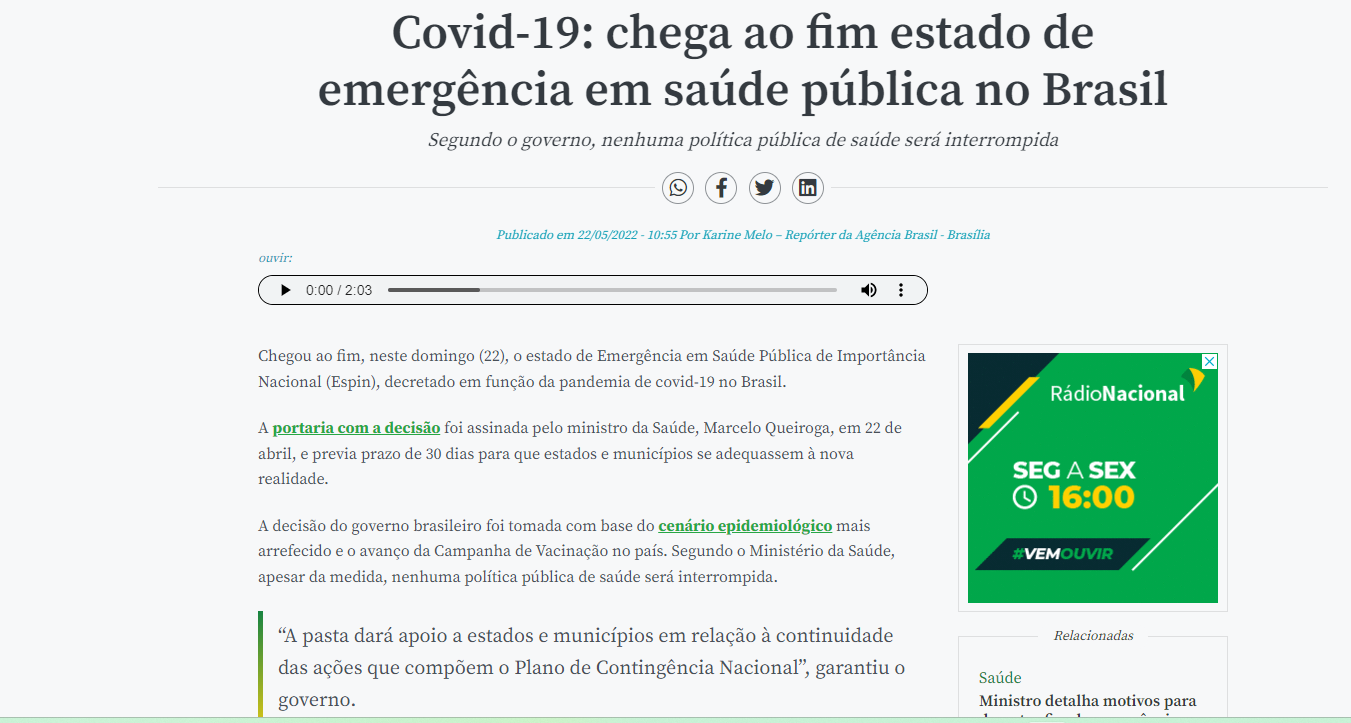


In [281]:
# Criando a coluna "Covid"
dados=dados.assign(Covid='xxx')
inicio_pandemia= pd.to_datetime('2020-03-15')
fim_pandemia=pd.to_datetime('2022-04-22')
for i in range(0,comp_dados):
    if dados['Data'][i]<inicio_pandemia:
        dados['Covid'][i]="Pré-Pandemia"
    elif dados['Data'][i]> fim_pandemia:
        dados['Covid'][i]="Pós-Pandemia"
    else:
        dados['Covid'][i]="Pandemia"
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-05-01           4635.59            54.42   
5            Sul 2023-04-30           5032.24            77.36   
9            Sul 2023-04-29           5510.53            84.71   
12           Sul 2023-04-28           6040.72            92.86   
17           Sul 2023-04-27           6542.25           100.57   
...          ...        ...               ...              ...   
26762   Nordeste 2005-01-05          11820.00            85.58   
26766   Nordeste 2005-01-04          11285.00            81.71   
26768   Nordeste 2005-01-03          10929.00            79.13   
26774   Nordeste 2005-01-02          10267.00            74.34   
26778   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4072.47                  47.81  20459.24    17169.44   
5                     4769.21                  73.3

In [282]:
# Exibindo as informações do DataFrame "final", incorporada a coluna "Covid"
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26780 entries, 1 to 26778
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              26780 non-null  object        
 1   Data                    26780 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        26780 non-null  float64       
 3   ENA_Bruta[%MLT]         26780 non-null  float64       
 4   ENA_Armazenavel[MWmed]  26780 non-null  float64       
 5   ENA_Armazenavel[%MLT]   26780 non-null  float64       
 6   EAR_max                 26780 non-null  float64       
 7   EAR[MWmes]              26780 non-null  float64       
 8   EAR[%max]               26780 non-null  float64       
 9   Carga_Diaria[MWmed]     26780 non-null  float64       
 10  CMO_semanal[R$/MWh]     26780 non-null  float64       
 11  CMO_leve[R$/MWh]        26780 non-null  float64       
 12  CMO_media[R$/MWh]       26780 non-null  float6

Portanto, o dataframe "dados" possui todos os valores "não-nulos", sendo as colunas 'Subsistema' e 'Covid' qualitativas.

In [283]:
# Verificando a distribuição das classes (Covid)
dados.groupby('Covid').size()

Covid
Pandemia         3076
Pré-Pandemia    22208
Pós-Pandemia     1496
dtype: int64

Numa etapa futura, que objetivará a predição do CMO, espera-se que o período da pandemia mereça algum tipo de tratamento especial, de modo a evitar vieses incorretos nas saídas dos modelos de Machine Learning, a ser tratado nos próximos Sprints.

In [284]:
# Redefinindo os datasets por subsistema, incorporando a coluna "Covid"
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [285]:
print(dados_SE)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-01          49780.29           124.73   
4        Sudeste 2023-04-30          50941.13            93.04   
8        Sudeste 2023-04-29          52268.25            95.47   
15       Sudeste 2023-04-28          53606.07            97.91   
16       Sudeste 2023-04-27          54910.46           100.29   
...          ...        ...               ...              ...   
26760    Sudeste 2005-01-05          45324.00            90.05   
26764    Sudeste 2005-01-04          44388.00            88.19   
26771    Sudeste 2005-01-03          43314.00            86.06   
26772    Sudeste 2005-01-02          43352.00            86.13   
26776    Sudeste 2005-01-01          43952.00            87.32   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[MWmes]  \
0                    32157.67                  80.57  204615.33   176417.73   
4                    32174.04                  58

## Visualizações Unimodais

### Histogramas

In [286]:
# Histograma para visualização dos dados de ENA_Bruta[MWmed];ENA_Bruta[%MLT]; EAR[MWmes]; EAR[%max]; Carga_Diaria[MWmed] e CMO_Semanal[R$/MWh]
# Carregando o estilo "seaborn-v0_8"
plt.style.use("seaborn-v0_8")

# Alterando alguns parâmetros gráficos
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

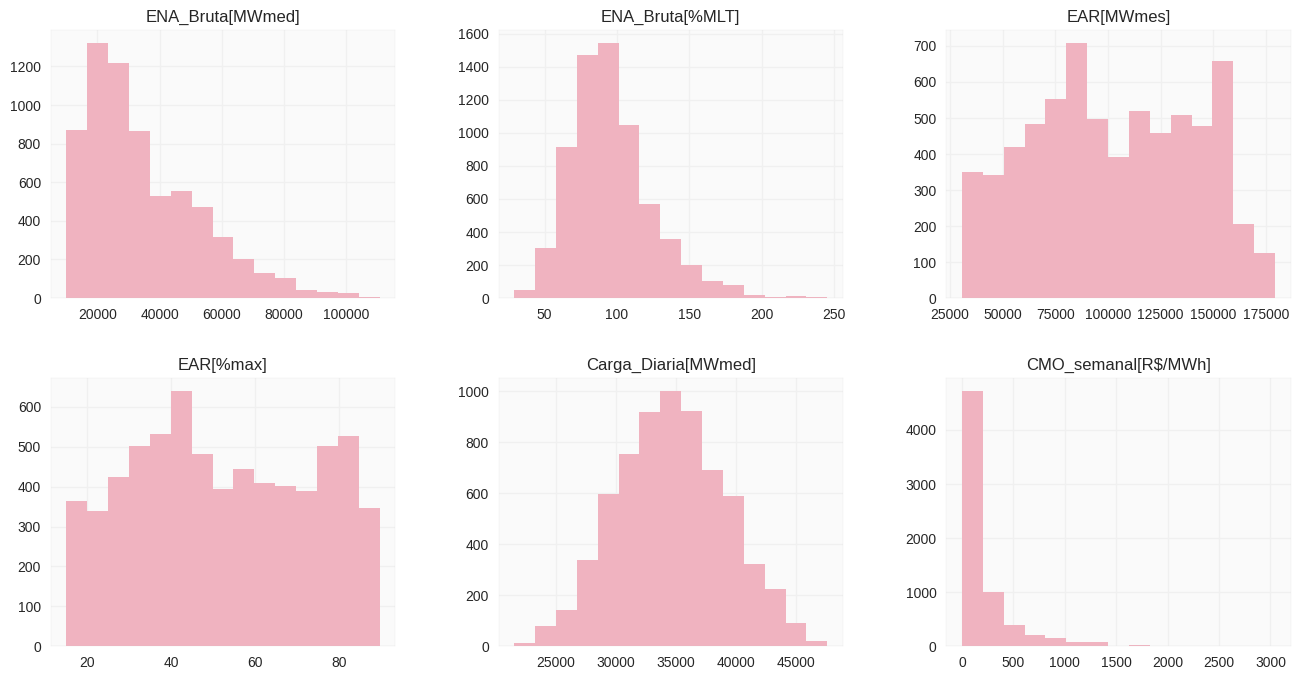

In [287]:
# Histograma Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#F0b3c0")
plt.show()

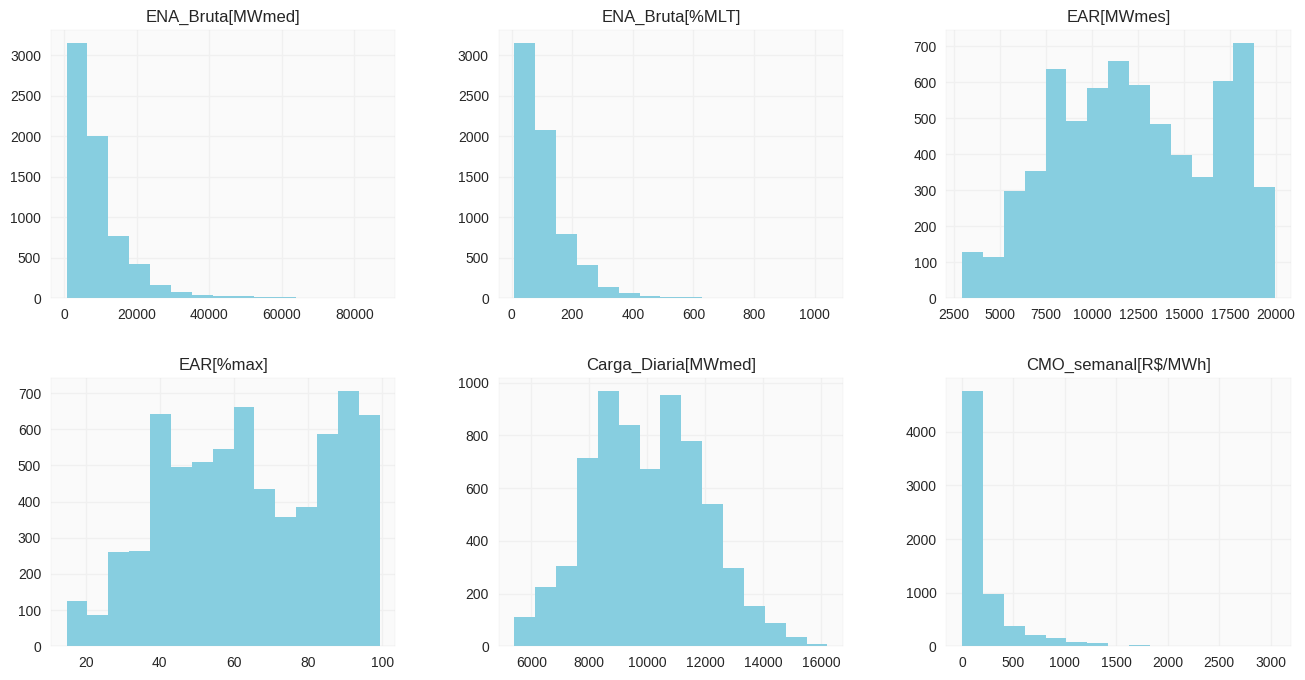

In [288]:
# Histograma Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#87cee0")
plt.bar_label
plt.show()

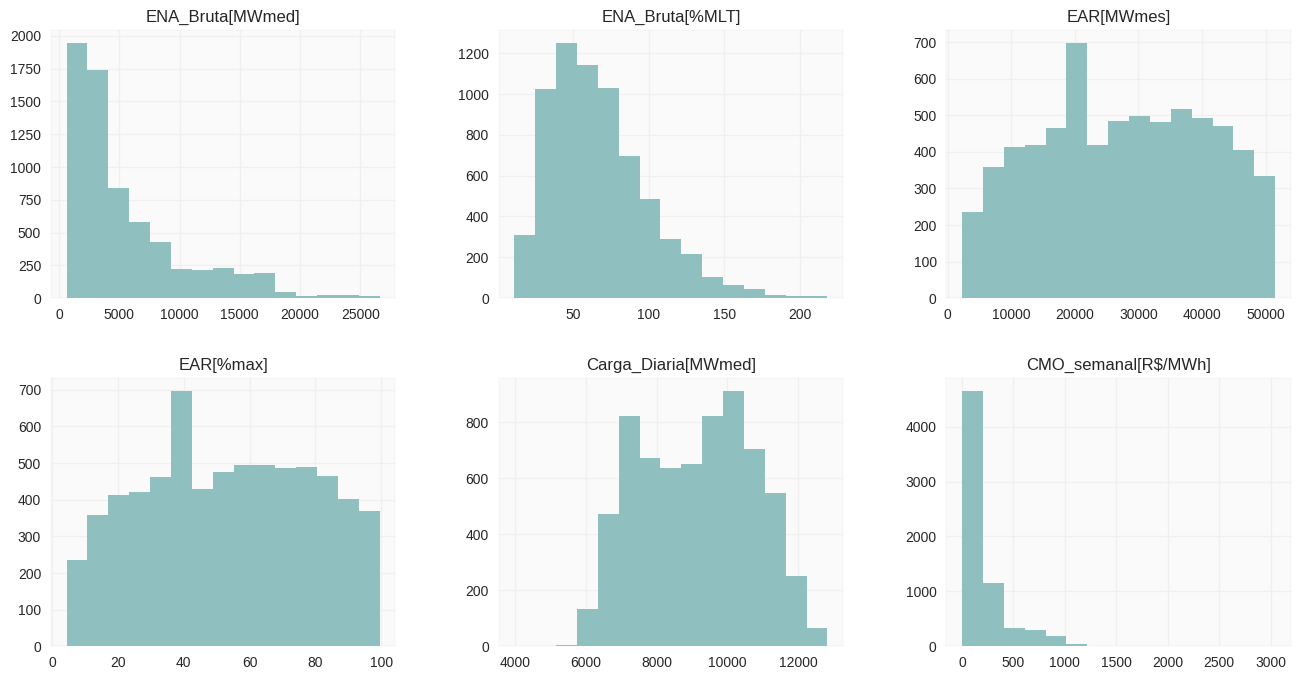

In [289]:
# Histograma Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#8FBfbF")
plt.show()

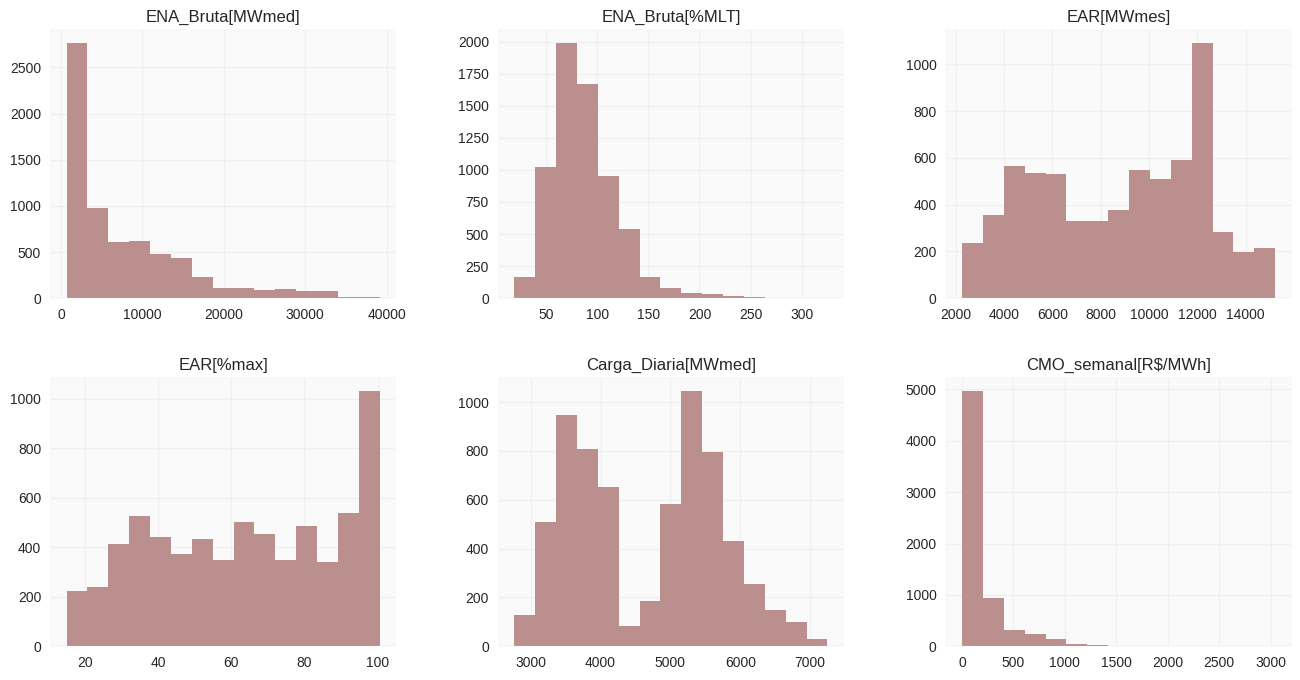

In [290]:
# Histograma Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15, layout = (2,3), figsize = (16,8), color="#BC8F8F")
plt.show()



> Pela análise dos histogramas, para todos os subsistemas o CMO semanal apresenta assimetria positiva, indicando que a enorme maioria dos valores encontra-se abaixo dos 250 Reais/MWh, embora haja valores extremos, ultrapassando os 3000 R$/MWh, conforme visto nas tabelas com as estatísticas descritivas.


> Em relação ao comportamento da carga diária, para o Sudeste, aproxima-se bastante de uma distribuição normal. Chama a atenção a carga do Norte: provavelmente, esse comportamento "dividido em dois blocos bem definidos" se deve à entrada/saída de algum grande consumidor, que faça com que a ocorrência de valores entre 4 e 5 GWmed seja baixa.


> Em relação aos reservatórios, é interessante observar como, para o subsistema Nordeste, a maior frequência de EAR (%máx) no período está na faixa dos 40%. E que Sudeste e Sul também tiveram reservatórios próximos a esse patamar em um número expressivo de dias.



> Sobre a ENA em % da MLT, todos os subsistemas apresentam assimetria à direita. Para o Sudeste, a maior frequência é próxima dos 80-100% da MLT.









### Boxplot

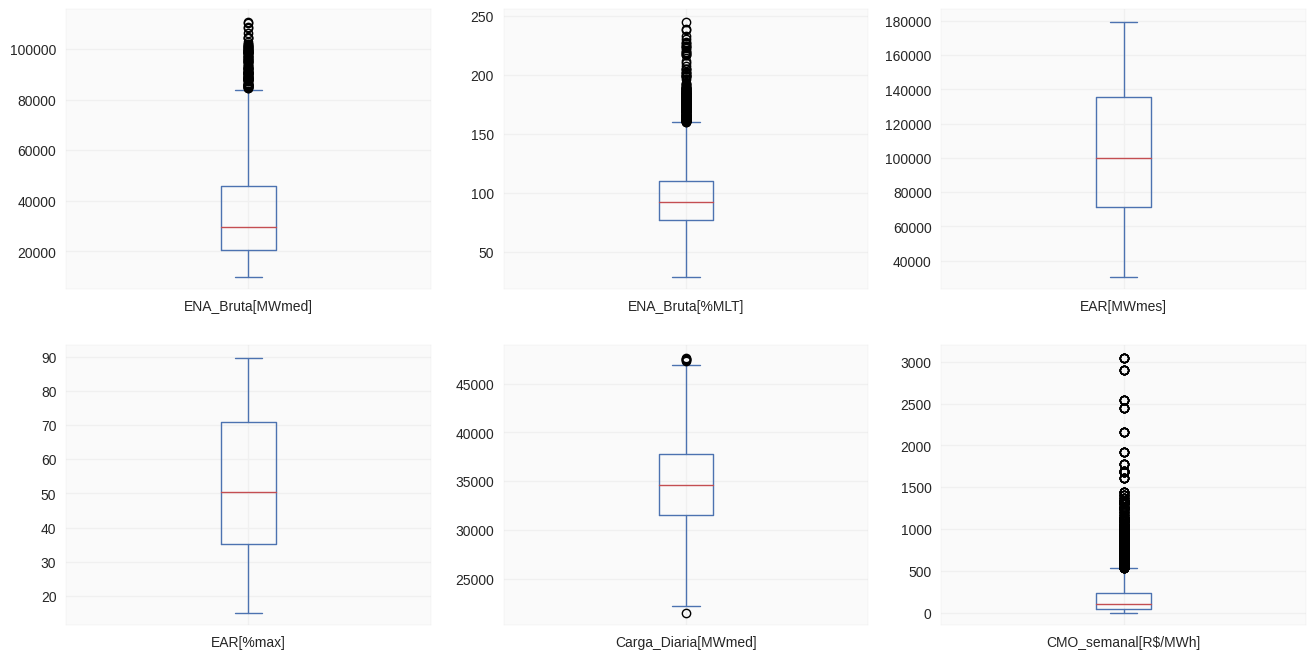

In [291]:
# Boxplot Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

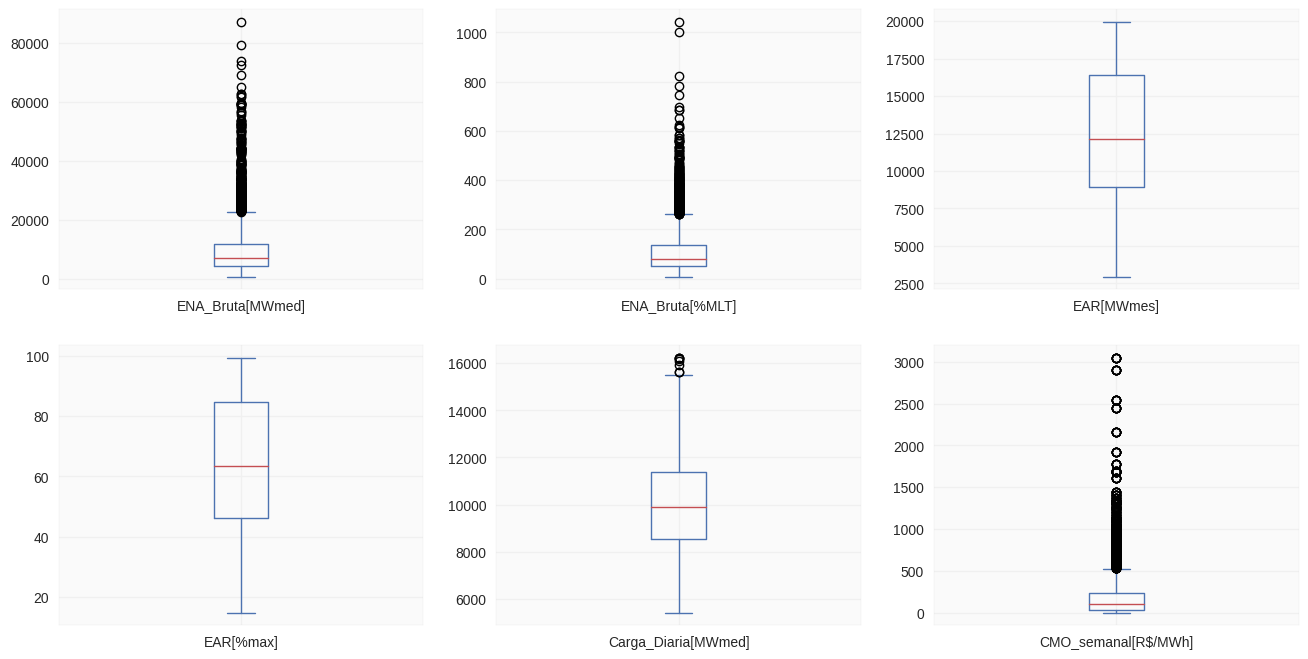

In [292]:
# Boxplot Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

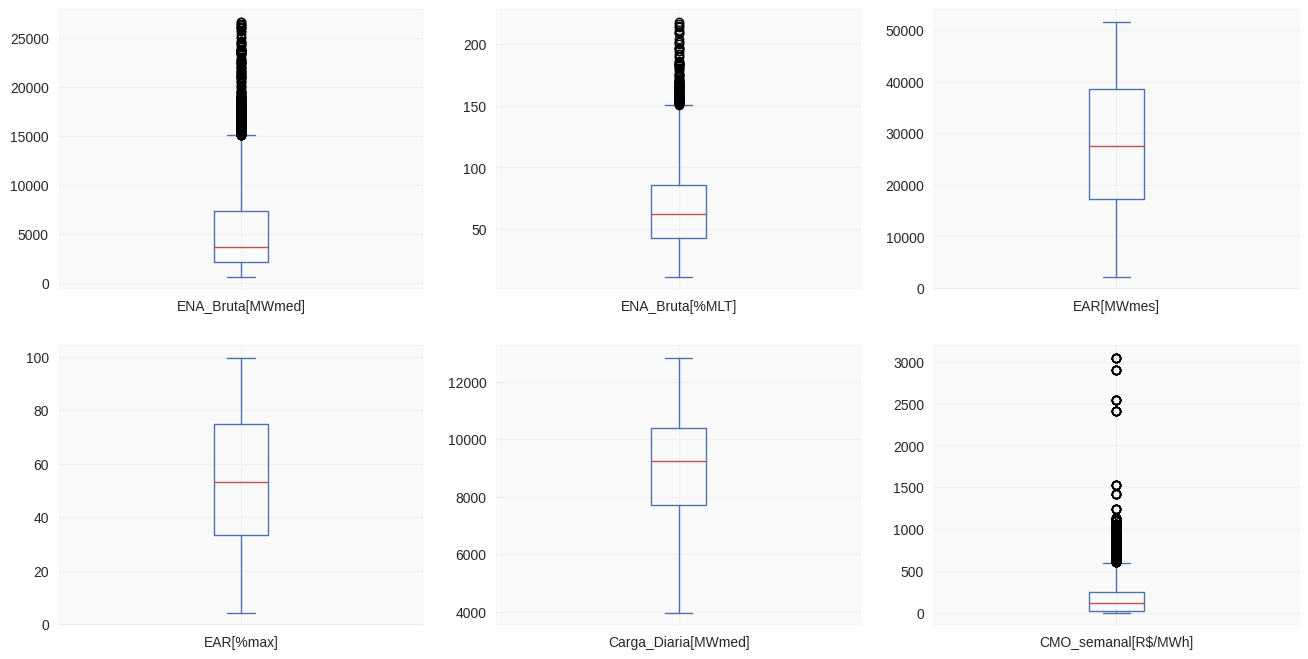

In [293]:
# Boxplot Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

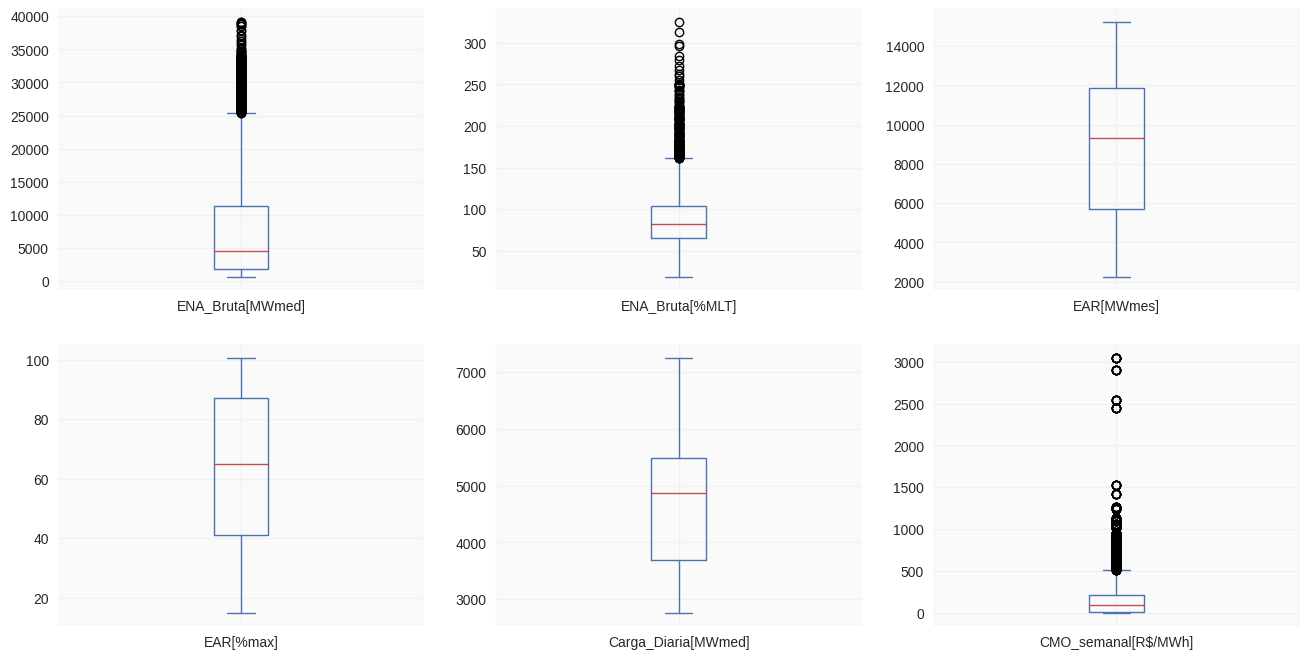

In [294]:
# Boxplot Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()



> A análise dos gráficos boxplot corrobora as constatações do histograma. Nas plotagens, a linha vermelha representa a mediana (imune a outliers). Para todos os subsistemas, observa-se que, em relação à Energia Armazenada, todos os valores encontram-se dentro dos limites do boxplot (tanto em MWmes quanto em %máximo). Este fato pode ser depreendido do histograma, pelo qual é possível perceber que não há diferenças significativas nas distribuições de probabilidade dos reservatórios, considerando um mesmo subsistema. Fato semelhante ocorre para os gráficos de carga diária. Neste ponto, destaca-se o fato de que, para a região Norte, o valor de P50 (próximo aos 5 GWmed) está bem mais próximo do valor correspondente ao terceiro quartil (P75) do que do primeiro (P25). Isso indica uma distribuição elevada de carga na faixa dos 5 ao 5,5 GWmed no referido subsistema. Para o Sul e Sudeste, alguns poucos valores acima do limite superior do intervalo.

> Em relação à ENA, no entanto, para todos os subsistemas se observam bastante valores fora dos limites do boxplot, característica das distribuições com assimetria à direita. Como destaque, para o Sul, houve uma ocorrência de ENA superior aos 1000% da MLT o que, certamente, configura um evento extremamente atípico em termos meteorológicos/climatológicos.


> Por fim, em relação ao CMO, observa-se que em 50% da amostra, os valores são inferiores a 150 Reais/MWh para os 4 subsistemas. O P75 não chega aos 250 Reais/MWh e o limite da faixa gira em torno dos 500 Reais/MWh. Nas etapas de predição/prescrição, faz-se necessário, portanto, maior atenção aos valores fora do intervalo, provavelmente correspondentes a períodos de grave escassez hídrica, como foi o biênio 2020-2021, quando os baixos valores de ENA e EArm levaram ao CMO de mais de 3000 Reais/MWh.






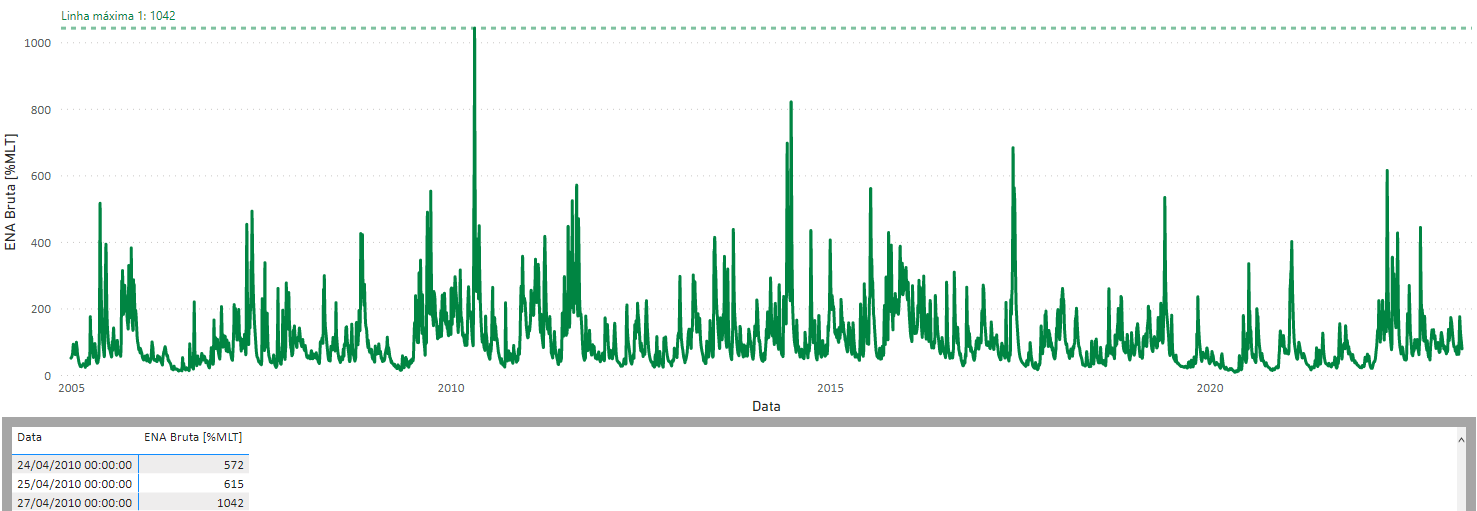
Data de ocorrência do evento de mais de 1000% da MLT na região Sul, correspondente a cerca de 60 GWmed (gráfico elaborado por meio do Power BI).

## Visualizações Multimodais

### Matriz de Correlação

<Axes: >

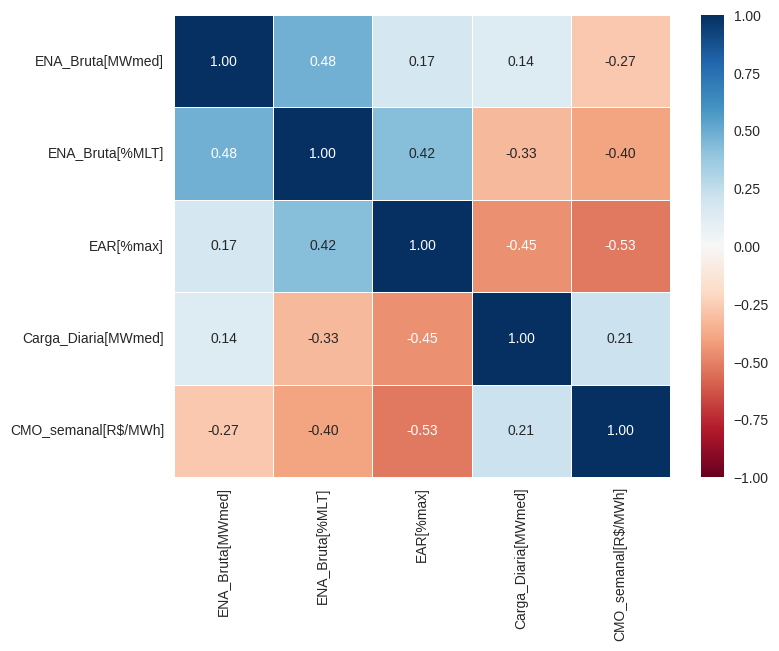

In [295]:
# Matriz de Correlação para o Sudeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True, 
            fmt = ".2f", cmap='RdBu', 
            linewidths=.5, 
            vmin = -1, vmax = 1)

<Axes: >

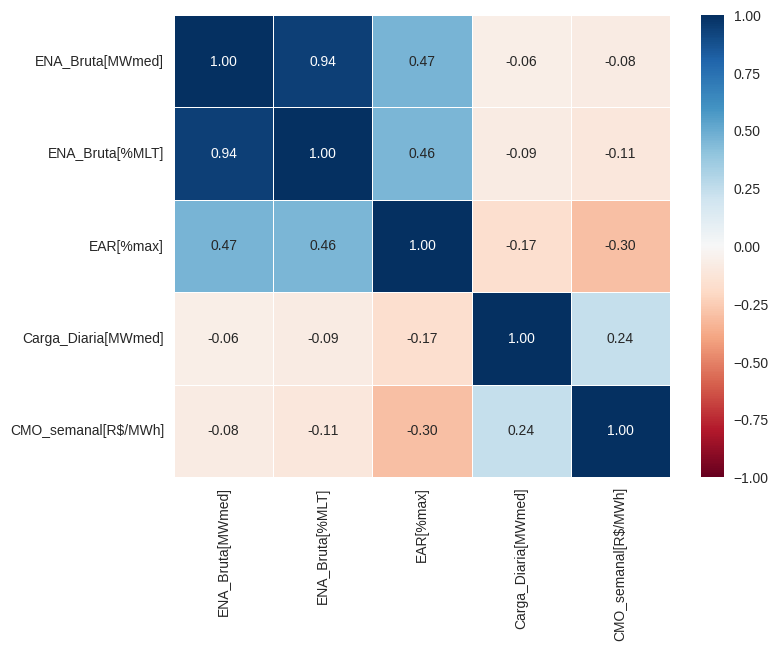

In [296]:
# Matriz de Correlação para o Sul
plt.figure(figsize=(8,6))
sns.heatmap(dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True, 
            fmt = ".2f", cmap='RdBu', 
            linewidths=.5, 
            vmin = -1, vmax = 1)

<Axes: >

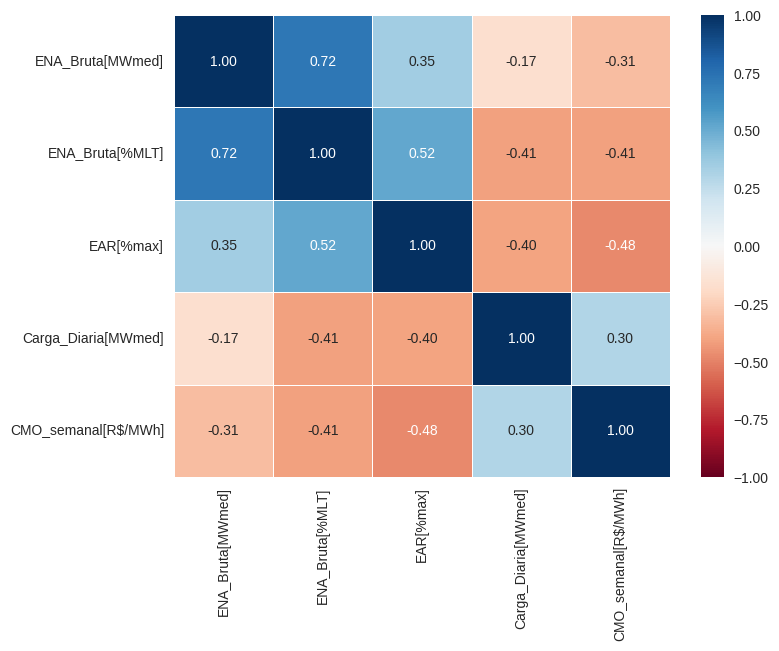

In [297]:
# Matriz de Correlação para o Nordeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True, 
            fmt = ".2f", cmap='RdBu', 
            linewidths=.5, 
            vmin = -1, vmax = 1)

<Axes: >

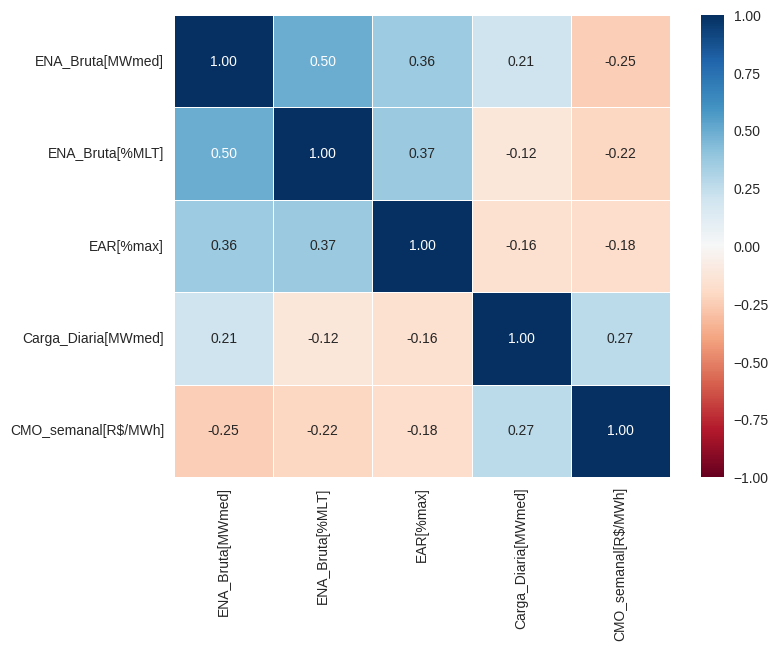

In [298]:
# Matriz de Correlação para o Norte
plt.figure(figsize=(8,6))
sns.heatmap(dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True, 
            fmt = ".2f", cmap='RdBu', 
            linewidths=.5, 
            vmin = -1, vmax = 1)

Conforme analisado anteriormente, considerando todo o horizonte de dados disponível (2005-dias atuais), é possível identificar uma correlação moderada (negativa) do CMO com a Energia Armazenada (em % do volume útil) e com a Energia Natural Afluente (em % da MLT) principalmente para o Sudeste e o Nordeste, que são os subsistemas com maior volume máximo de reservatórios do SIN. Para a carga, a correlação é positiva moderada, em todos os subsistemas, conforme esperado "intuitivamente". É possível constatar ainda que ENA (%MLT) e EArm (%máx) se correlacionam positivamente. Esse comportamento faz sentido, uma vez que na ocorrência de chuvas (e, consequentemente, de elevação da ENA) espera-se que os reservatórios (EArm) também se encham. As políticas operativas, no entanto, podem acabar levando a maiores ou menores deplecionamentos dos reservatórios das usinas hidroelétricas, por fora dos modelos, a depender da conjuntura hidrológica e do balanço energético do Sistema Interligado Nacional. 

### Scatter Plot

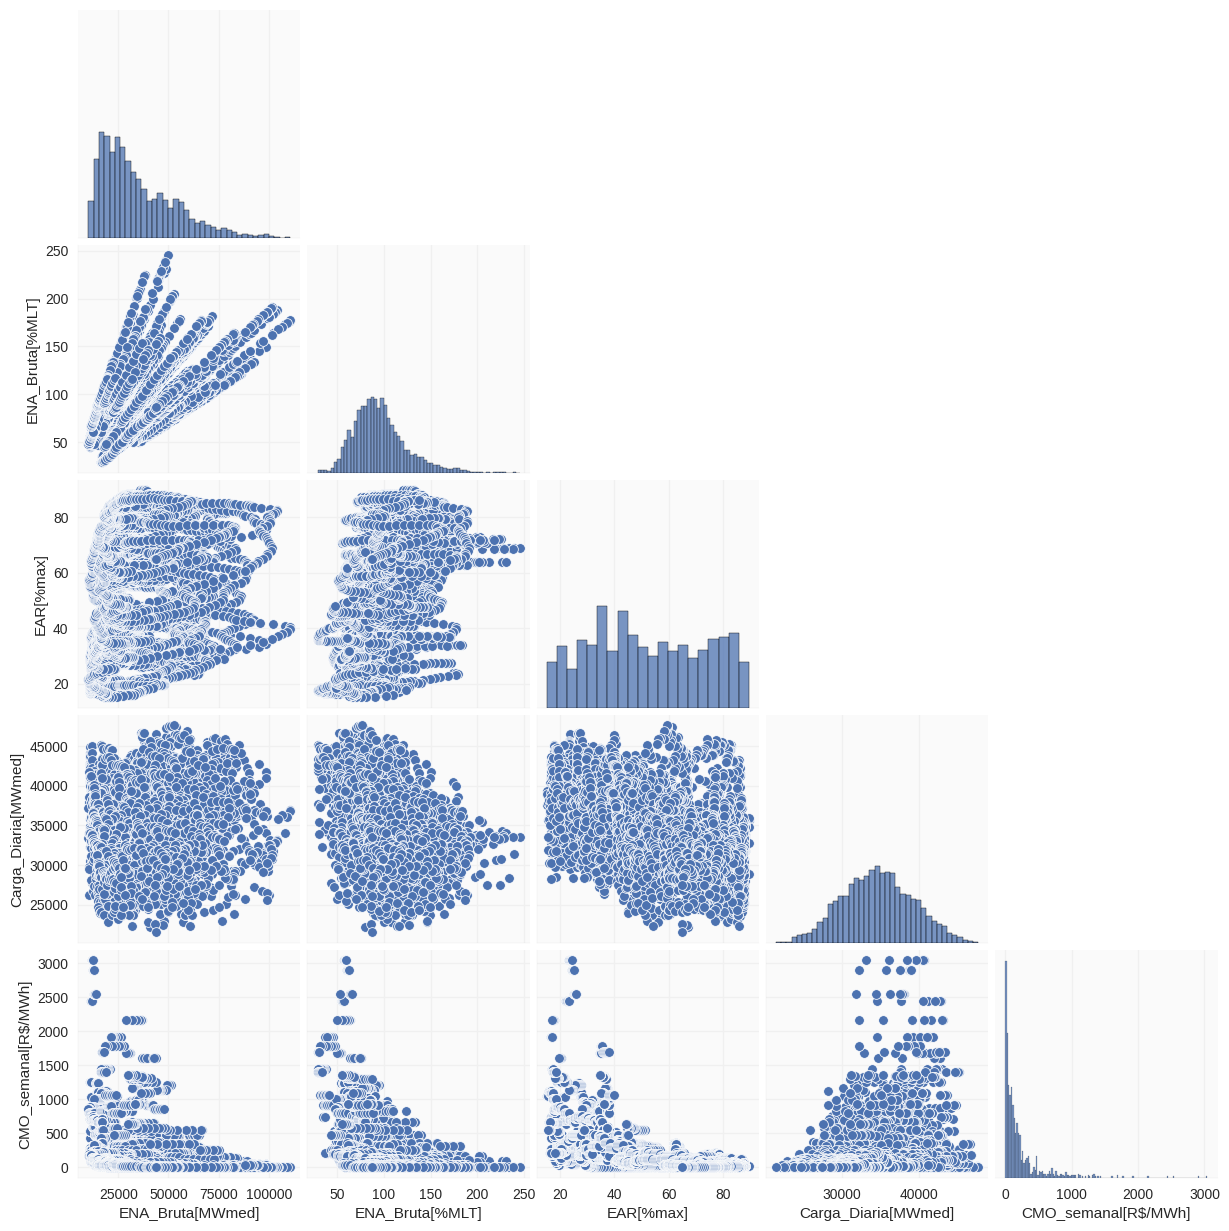

In [299]:
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
# Scatter Plot com Seaborn - Sudeste
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']], corner=True)

Pela avaliação do scatter-plot, podemos observar como os maiores valores de CMO semanal ocorrem para valores de ENA Bruta inferiores a 75% da MLT e para reservatórios abaixo dos 40% do volume útil no Sudeste. É possível observar também que o CMO de 0 R$/MWh nunca ocorreu em casos de ENA diária inferior a 50% da MLT no Sudeste. Um outro destaque é o fato de os maiores valores de CMO não terem ocorrido para valores mínimos de ENA em % da MLT (e sim próximo aos 60%), mas, para ENAs muito baixas em termos absolutos (MWmed). Isto nos leva a crer que esses Custos muito elevados se deram em algum mês de MLT mais baixa (ou seja, de valores históricos de chuva mais baixos, pela sazonalidade/climatologia. Provavelmente, entre junho e novembro, meses do chamado "período seco"). Além disso, para reservatórios superiores a 50%-55%, o CMO não ultrapassou os 500 Reais/MWh que, como vimos no Boxplot, é o limite superior do mesmo. Em relação à carga, à exceção de valores outlier de CMO, o comportamento da curva Carga x CMO parece ter uma tendência de distribuição normal, para a qual valores mais elevados de CMO ocorrem em cargas intermediárias, entre 30 e 40 GWmed. Esse comportamento não é intuitivo, a princípio. Porém, como pode ser visto no gráfico de ENA Bruta (MWmed) x Carga, os maiores valores de ENA ocorreram para cargas de aproximadamente 35 GWmed e isso poderia explicar o comportamento do CMO (embora essa relação ENA x Carga possa ser uma coincidência em função da pandemia - menor carga e El Niño - condições climáticas - menor ENA). Para trabalhos futuros, fazem-se necessárias avaliações mais detalhadas a respeito.

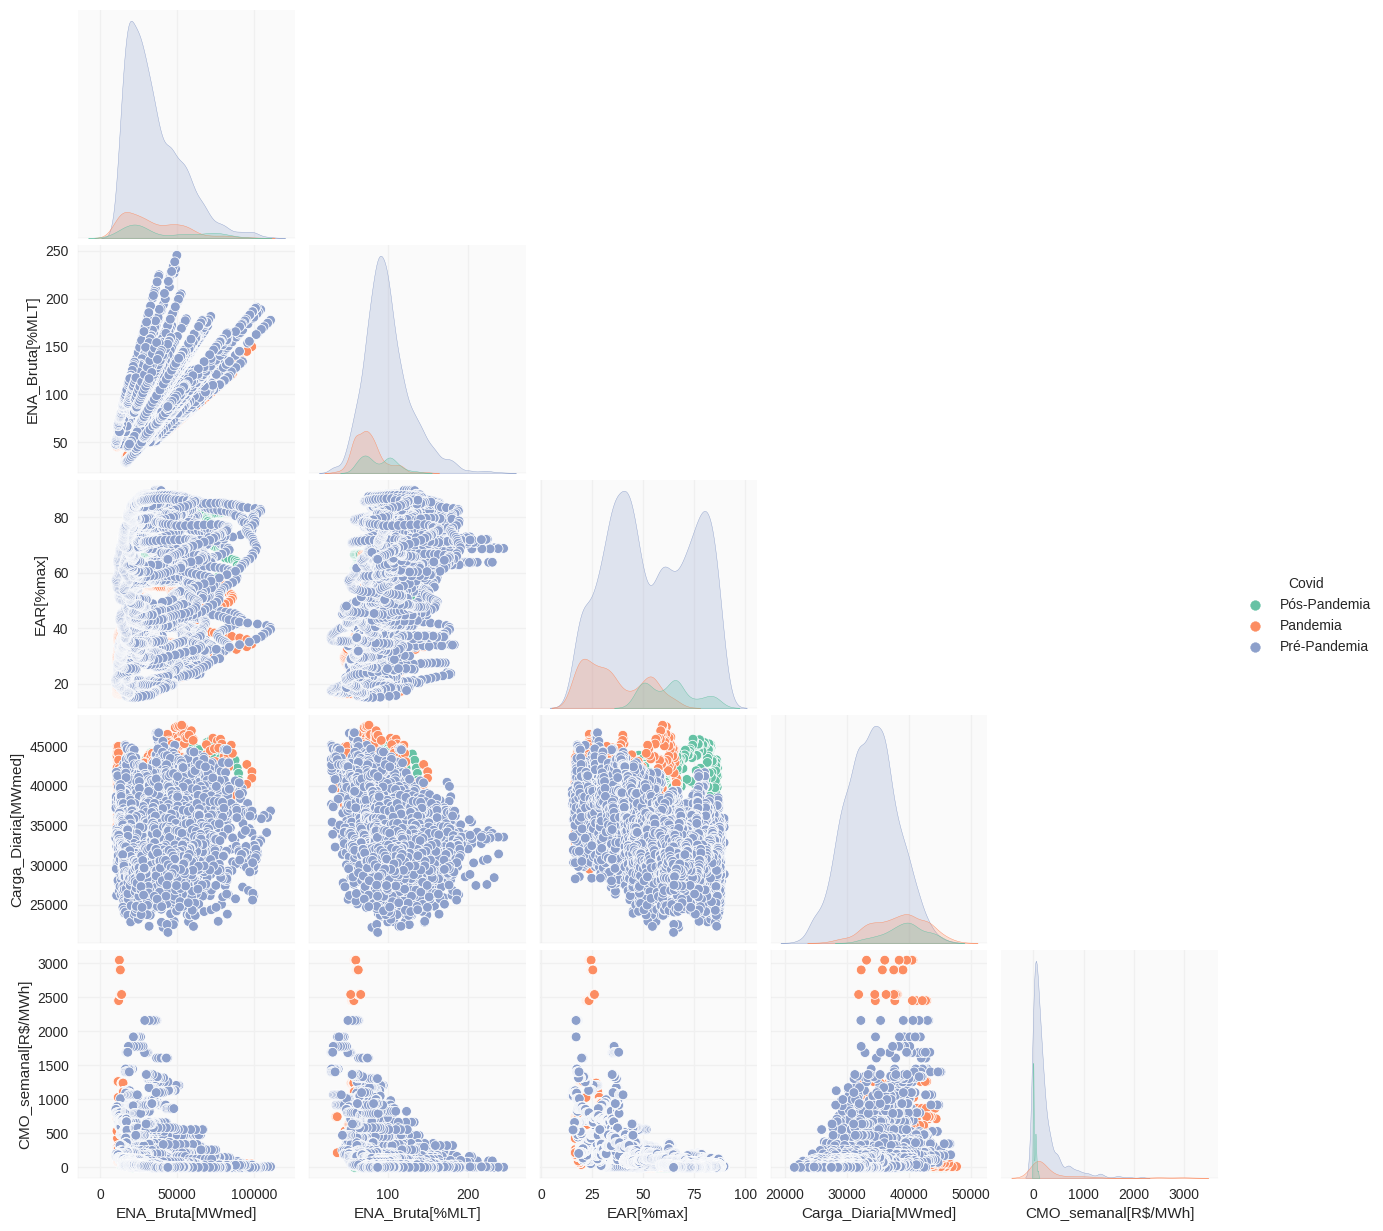

In [300]:
# Scatter Plot considerando a variável qualitativa referente à pandemia de Covid-19
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','Covid']], hue = "Covid", height = 2.5, corner=True, palette="Set2")

A principal interferência da pandemia de Covid-19 nas grandezas avaliadas diz respeito à carga. Embora, coincidentemente (mas sem nenhum tipo de relação causal), os valores de ENA (em MWmed e em % da MLT) tenham tido uma distribuição mais assimétrica à direita no período da pandemia do que no período anterior a ela. É necessário, em análises futuras (e no treinamento dos modelos de ML) cautela neste aspecto, para que os algoritmos não indiquem correlações indevidas entre a pandemia e a ENA. Em relação à carga, durante a pandemia (e no pós), o que enxergamos é um deslocamento da curva para uma assimetria mais à esquerda. Para análises futuras, é interessante avaliar os anos imediatamente anteriores à pandemia (talvez encurtar o horizonte, neste caso, por exemplo), para tentar entender melhor os efeitos. Além disso, no durante e pós-pandemia observa-se um desvio-padrão maior (da carga) em comparação aos anos prévios. Sobre a correlação com o CMO, observamos que os maiores valores de CMO registrados ocorreram durante a pandemia, mesmo para cargas intermediárias que, fora da pandemia, levaram o custo no máximo a 70% dos 3000 Reais/MWh). E este fato provavelmente se explica pelos valores mais severos de ENA e EArm no intervalo de 2020 a 2022.

# Avaliações Temporais no Power BI

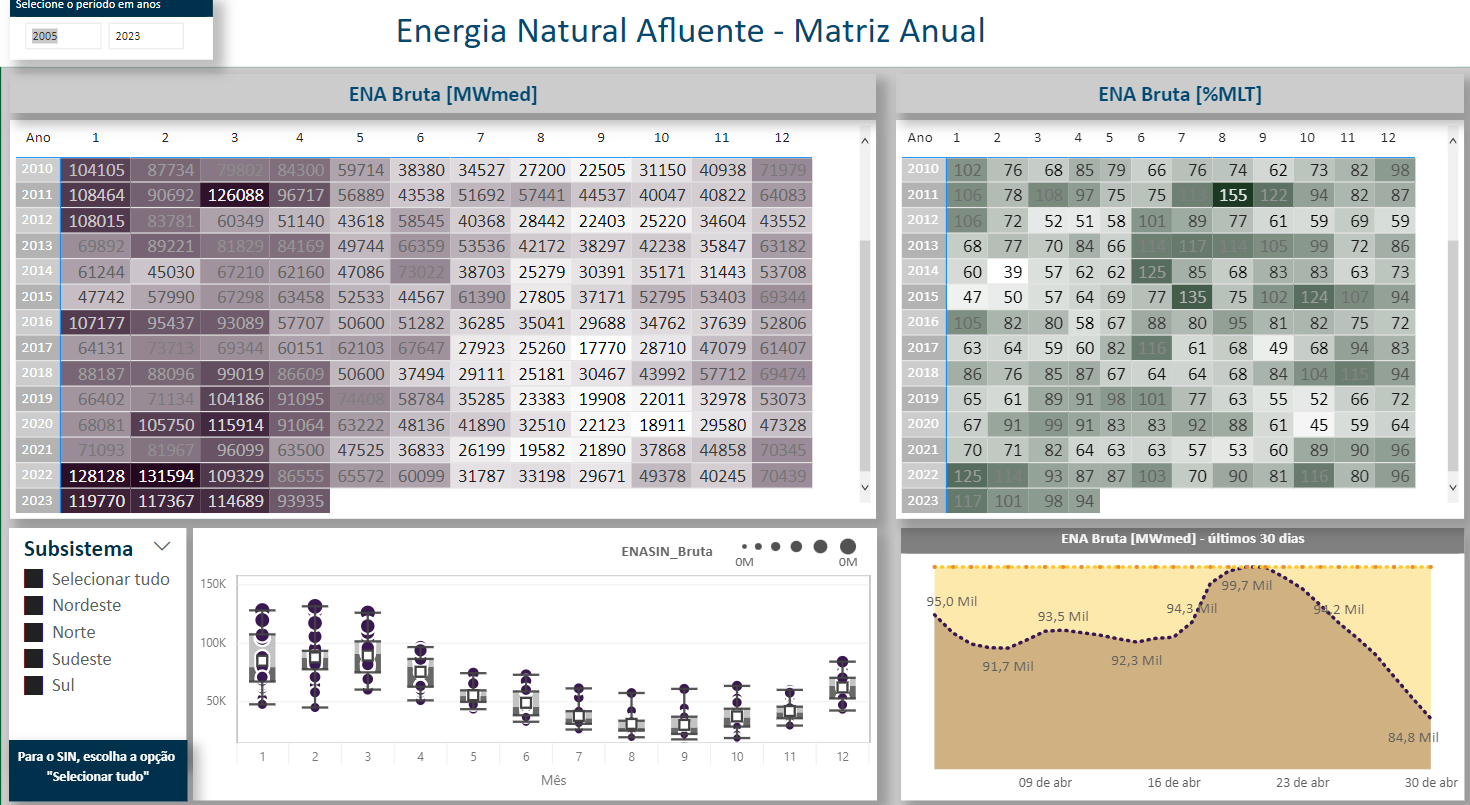

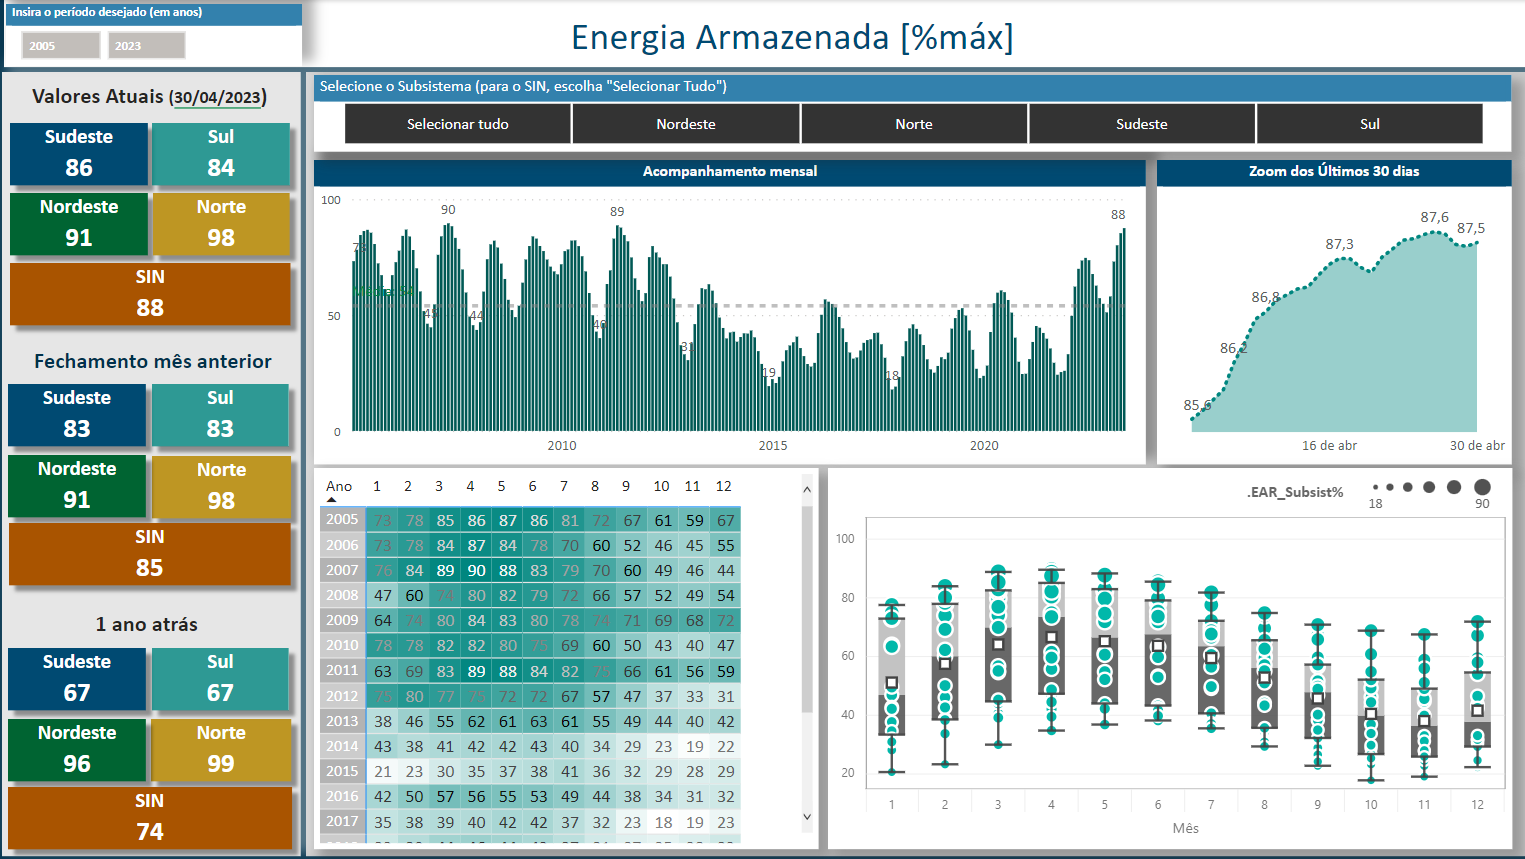

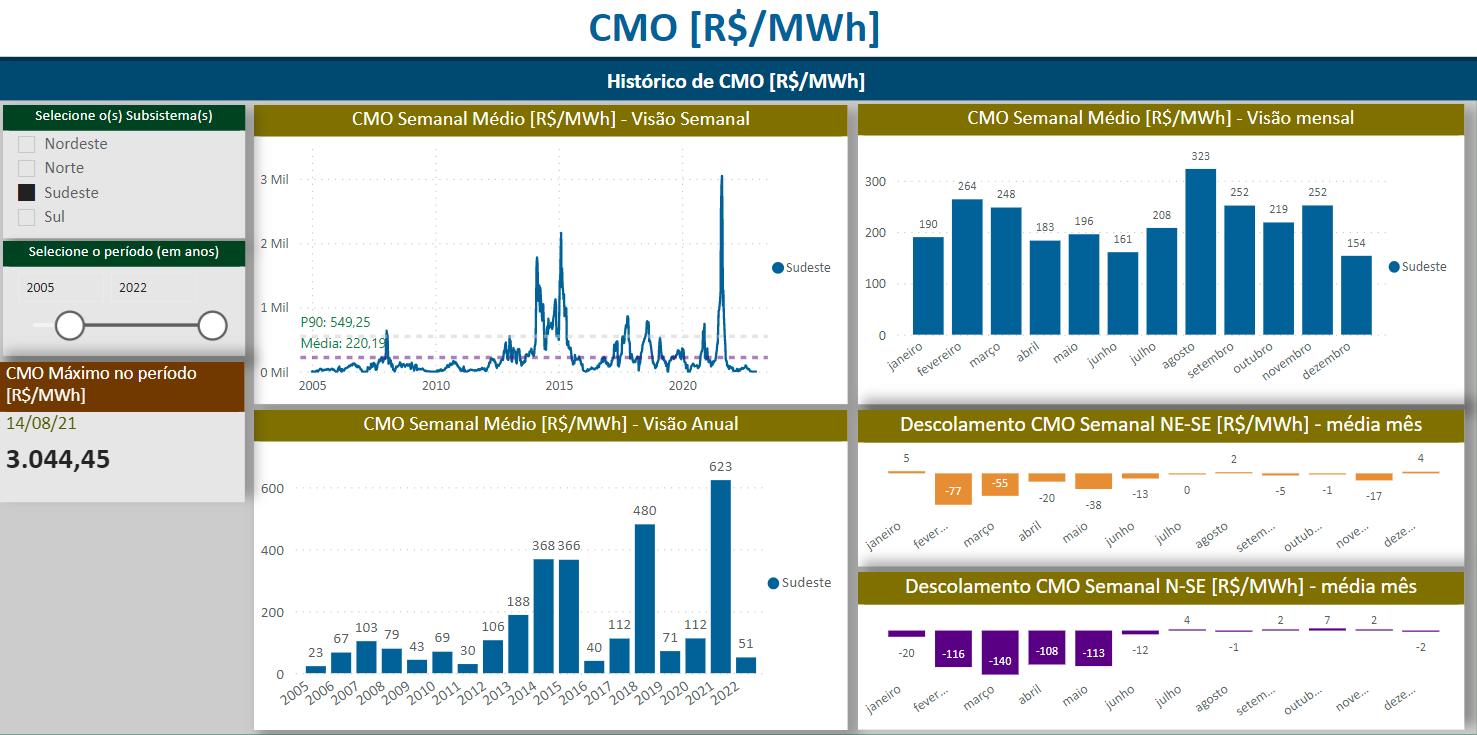

Os dados obtidos a partir da Área de Dados Abertos do ONS foram importados no Power BI (via Power Query) e, em seguida, foram gerados os dashboard acima. Pelas visualizações, pode-se concluir, por exemplo, que: desde 2011, o mês de abril não registrava ENA (% da MLT) tão alta. Além disso, pelo boxplot de ENA é possível identificar a sazonalidade do período chuvoso/seco no Brasil, de modo que dezembro a abril são os meses de maior mediana (período úmido). Em relação ao histórico recente, observa-se uma queda de mais de 10 GWmed de ENA no SIN entre o final de março e o final de abril o que é, de certa forma, esperado pela climatologia dos referidos meses. Apesar da redução da ENA (em termos absolutos) os reservatórios do SIN sofreram uma elevação no último mês. Quando comparados ao mesmo período de 2022 (30/04/23 vs 30/04/22), a crescente é muito expressiva, principalmente no Sul e no Sudeste. Podemos perceber que o enchimento/deplecionamento dos reservatórios tem um comportamento cíclico ao longo de um ano e que, desde 2011, não observávamos condições tão favoráveis de energia armazenada quanto atualmente. Em relação ao CMO médio no decorrer dos anos, observa-se que, de fato, 2011 teve valores baixíssimos do custo de operação médio. Também é possível observar que 2021, quando as ENAs ficaram muito baixas, o preço médio anual foi o maior do histórico e que basta um ano favorável ou desfavorável em termos de chuva para alterar a tendência de CMO do ano anterior. Em relação aos valores médios nos meses, observa-se que agosto (mês de menor MLT no Sudeste) é o de maior CMO médio, ao passo que dezembro (início do período úmido), o de menor. Em relação aos valores por subsistema, observa-se que nos meses chuvosos, dentro do horizonte analisado, em geral o CMO do Nordeste e do Norte foi menor que o do Sudeste. Este aspecto está diretamente relacionado à capacidade de fluxo de energia entre os subsistemas e, considerando ampliações e reforços na transmissão, pode não ser mais replicável daqui em diante.


# Seção IV: Pré-Processamento de Dados - Parte 2


> Ao longo das seções/etapas anteriores, já realizamos várias atividades de pré-processamento de dados, de modo a deixar nosso DataFrame mais "enxuto", menos "redundante" e mais adequado para aplicação de Modelos de Machine Learning. Neste momento, iremos reduzir ainda mais a dimensionalidade e realizar algumas transformações numéricas.



## Redução da Dimensionalidade

In [301]:
# Reduzindo a dimensionalidade do dataset dados, excluindo as colunas de CMO por patamar
dados=dados[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_SE=dados_SE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_S=dados_S[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_NE=dados_NE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_N=dados_N[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]

# Avaliando as 20 primeiras linhas do dataset dados
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-05-01        Sul           4635.59            54.42   
5  2023-04-30        Sul           5032.24            77.36   
9  2023-04-29        Sul           5510.53            84.71   
12 2023-04-28        Sul           6040.72            92.86   
17 2023-04-27        Sul           6542.25           100.57   
21 2023-04-26        Sul           6831.20           105.01   
25 2023-04-25        Sul           7138.59           109.74   
28 2023-04-24        Sul           7562.67           116.26   
33 2023-04-23        Sul           8170.22           125.60   
37 2023-04-22        Sul           8905.86           136.91   
41 2023-04-21        Sul           9793.16           150.55   
44 2023-04-20        Sul          10824.55           166.40   
49 2023-04-19        Sul          11373.89           174.85   
53 2023-04-18        Sul           9948.43           152.93   
58 2023-04-17        Sul           6796.91           104.49   
60 2023-04-16        Sul           4780.29            73.49   
65 2023-04-15        Sul           4288.05            65.92   
69 2023-04-14        Sul           4030.83            61.96   
73 2023-04-13        Sul           4260.46            65.49   
76 2023-04-12        Sul           4611.40            70.89   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  4072.47                  47.81  20459.24      83.92   
5                  4769.21                  73.32  20459.24      84.00   
9                  5155.08                  79.25  20459.24      83.97   
12                 5899.60                  90.69  20459.24      83.98   
17                 6173.40                  94.90  20459.24      84.23   
21                 4291.69                  65.97  20459.24      84.51   
25                 4878.17                  74.99  20459.24      84.71   
28                 6550.44                 100.70  20459.24      84.99   
33                 3111.69                  47.84  20459.24      84.85   
37                 3785.07                  58.19  20459.24      84.94   
41                 5911.41                  90.87  20459.24      84.96   
44                 7113.25                 109.35  20459.24      84.87   
49                 6838.85                 105.13  20459.24      85.00   
53                 3561.55                  54.75  20459.24      84.79   
58                 6289.95                  96.69  20459.24      84.75   
60                 4463.59                  68.62  20459.24      84.32   
65                 4003.65                  61.55  20459.24      84.04   
69                 3926.07                  60.35  20459.24      83.91   
73                 4155.40                  63.88  20459.24      84.04   
76                 4508.91                  69.31  20459.24      84.12   

    Carga_Diaria[MWmed]         Covid  CMO_semanal[R$/MWh]  
1              10072.19  Pós-Pandemia                  0.0  
5               9635.53  Pós-Pandemia                  0.0  
9              11012.29  Pós-Pandemia                  0.0  
12             12247.46  Pós-Pandemia                  0.0  
17             12578.77  Pós-Pandemia                  0.0  
21             12626.74  Pós-Pandemia                  0.0  
25             12557.10  Pós-Pandemia                  0.0  
28             11822.70  Pós-Pandemia                  0.0  
33              8646.55  Pós-Pandemia                  0.0  
37              9310.24  Pós-Pandemia                  0.0  
41              9641.26  Pós-Pandemia                  0.0  
44             11225.17  Pós-Pandemia                  0.0  
49             11500.87  Pós-Pandemia                  0.0  
53             12071.94  Pós-Pandemia                  0.0  
58             12421.00  Pós-Pandemia                  0.0  
60              9788.41  Pós-Pandemia                  0.0  
65             11277.52  Pós-Pandemia                  0.0  
69             13234.98  Pós-Pan

In [302]:
# Confirmando novamente a ausência de dados faltantes
dados.isnull().sum()

Data                      0
Subsistema                0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
Covid                     0
CMO_semanal[R$/MWh]       0
dtype: int64

In [303]:
# Exibindo as dimensões de cada dataset
print("SIN:")
print(dados.shape)
print("Sudeste:")
print(dados_SE.shape)
print("Sul:")
print(dados_S.shape)
print("Nordeste:")
print(dados_NE.shape)
print("Norte:")
print(dados_N.shape)

SIN:
(26780, 11)
Sudeste:
(6695, 11)
Sul:
(6695, 11)
Nordeste:
(6695, 11)
Norte:
(6695, 11)


## Preparação para os Algoritmos de ML

In [305]:
# Separando cada dataset (por subsistema) em componentes de "entrada" e "saída"
# SIN
X= dados.values[:,2:10]
y=dados.values[:,10]
# Sudeste
X_SE= dados_SE.values[:,2:10]
y_SE=dados_SE.values[:,10]
# Sul
X_S= dados_S.values[:,2:10]
y_S=dados_S.values[:,10]
# Nordeste
X_NE= dados_NE.values[:,2:10]
y_NE=dados_NE.values[:,10]
# Norte
X_N= dados_N.values[:,2:10]
y_N=dados_N.values[:,10]